In [1]:
import pathlib as pl

import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("colorblind"))

import itertools, warnings

from collections import Counter, defaultdict
from typing import List, Dict, Tuple

In [2]:
def canonic_model_name(model_name: str):
    if "EleutherAI__" in model_name:
        model_name = model_name.replace("EleutherAI__", "")
    elif "facebook__" in model_name:
        model_name = model_name.replace("facebook__", "")
    elif "llama" in model_name:
        ix = model_name.index("llama")
        model_name = model_name[ix:].replace("__hf_models__", "-")
    elif "mosaicml__" in model_name:
        model_name = model_name.replace("mosaicml__", "")
        
    if "deduped" in model_name:
        model_name = model_name.replace("-deduped", " (D)")
    return model_name


def get_model_size(canonic_name: str) -> int:
    import re 
    val = re.search(r"(\d+(\.\d+)?)(b|B|m|M)", canonic_name)[0]
    const = 1_000 if val[-1] in ("b", "B") else 1        
    return float(val[:-1]) * const

## Evaluating sentence-level differences between the different benchmarks


In this notebook, we will focus on trying to characterie the differences between the different benchmarks.
Before we delve in, let us clear out some confusion... In this work, we're dealing with two different things:
(A) **words** that may (or not) be associated with gender; (B) whether the **sentences are *neutral* or not**, irrespective of whether the words are associated with gender or not. 


For (B), we have curated a set of prompts and conducted human evaluation to validate our claims. That is, we've characterize the distribution and showed that both pronouns fit and this verifies for our datasets as well as the coreference ones (the ones that are created to be neutral by default). It may not be the case for stereotypical/antisterreotypical, depending on how they are constructed...


This notebook focuses on **A** and finding whether the words are associated with gender or not and, in particular, whether the words in our sentences also satisfy this property.

---

This notebook is structured as follows: 

1. Are there significant differences between our proposed benchmark and the existing ones? 
2. Are other benchmarks significantly more gender-skewed (e.g., as measured by the lexicon)? 
3. Are other benchmarks significantly more gender-skewed (e.g., as measured by our PMI diff)? What's the highest PMI diff in the considered sentences?


### In this notebook 


In [3]:
from utils import GROUP_PAIRED_WORDLIST, FEMALE_WORDS, MALE_WORDS

In [4]:
BASE_DIR = "/extra/ucinlp1/cbelem/projects/bias-diagnosis"

# loads the PMI information precomputed based on the PILE co-occurrence counts
GENDER_PMI = pd.read_csv(f"{BASE_DIR}/word2gender_pmi_PILE.csv", index_col=0)
print(len(GENDER_PMI))
GENDER_PMI.describe()

152515


,pmi__her,pmi__his,pmi__him,pmi__hers,pmi__mother,pmi__father,pmi__mom,pmi__dad,pmi__mummy,pmi__daddy,...,pmi__queen,pmi__king,pmi__queens,pmi__kings,pmi__princess,pmi__prince,pmi__princesses,pmi__princes,pmi__he,pmi__she
count,80439.000000,98771.000000,65608.000000,7537.000000,30706.000000,29684.000000,10998.000000,10495.000000,1717.000000,2977.000000,...,10119.000000,19446.000000,3313.000000,6617.000000,5412.000000,8203.000000,1266.000000,3825.000000,100828.000000,66891.000000
mean,-24.827642,-24.861843,-24.803681,-24.205257,-24.915487,-24.912725,-25.195694,-25.311220,-24.439117,-25.298108,...,-25.361834,-25.395301,-24.835216,-24.729553,-25.019586,-25.328138,-23.698000,-23.932025,-25.416424,-25.262707
std,1.563299,1.580690,1.506580,1.445382,1.324532,1.342077,1.403486,1.310585,1.538892,1.450787,...,1.435780,1.500407,1.723579,1.696653,1.477100,1.462137,1.718849,1.715749,1.514534,1.499545
min,-33.499275,-33.331670,-33.613325,-30.640672,-30.936595,-30.878193,-30.376505,-30.894450,-29.312282,-30.237593,...,-30.485745,-31.237119,-28.636829,-29.793686,-30.302262,-31.337065,-30.067307,-29.995963,-32.885207,-33.474327
25%,-25.685422,-25.682861,-25.638325,-25.184315,-25.755291,-25.742207,-26.175983,-26.204275,-25.419204,-26.245775,...,-26.331394,-26.407824,-25.942235,-25.915272,-26.010199,-26.314027,-24.823475,-25.134534,-26.219694,-26.079852
50%,-24.622905,-24.552552,-24.605622,-24.219955,-24.857188,-24.823301,-25.178166,-25.242244,-24.648881,-25.315466,...,-25.429962,-25.440690,-25.287083,-24.966771,-25.088823,-25.347642,-24.085664,-24.178638,-25.137871,-25.078310
75%,-23.743398,-23.767377,-23.746094,-23.240134,-24.040494,-24.000929,-24.242664,-24.399705,-23.807955,-24.462129,...,-24.524708,-24.469532,-24.229567,-23.792893,-24.122755,-24.380551,-22.893234,-22.914827,-24.351869,-24.212292
max,-20.458226,-20.727246,-19.520618,-18.544282,-18.927156,-19.795987,-17.653614,-18.349328,-16.823430,-15.609870,...,-17.835727,-18.720616,-16.770424,-17.806201,-17.986234,-18.367298,-15.972031,-16.816626,-20.899774,-21.228257


In [5]:
def get_pmi_diff(df: pd.DataFrame, col1: str, col2: str, clip: int=None, missing_val: float=0, prefix_col: str="pmi__") -> pd.Series:
    """Obtains the PMI difference between columns col1 and col2. 
    
    Parameters
    ----------
    df: pandas.DataFrame
    
    col1: str
        The female word to use for computing the PMI. Should be one of the
        available suffixes in the provided dataframe's columns.
    
    col2: str
        The male word to use for computing the PMI. Should be one of the
        available suffixes in the provided dataframe's columns.
        
    clip: int, optional
        Positive integer, specifies the cap. If not specified, the pmi
        difference is only computed for words that co-occur with both
        (col1, col2). If specified, we will fill the PMI value with 0
        (ideally it would be a very negative number). You can tweak
        this value using 'missing_val'.
        
    prefix_col: str
        The prefix anteceding the col1 and col2 in the provided dataframe.
        In our files, we prefixes all columns with gendered lexicons using
        the "pmi__" prefix.
    
    Note
    ----
    To replicate the values of the paper you should pass female lexicon words
    as col1 and male lexicon words as col2.
    """
    assert f"{prefix_col}{col1}" in df.columns, f"column {col1} is undefined in dataframe"
    assert f"{prefix_col}{col2}" in df.columns, f"column {col2} is undefined in dataframe"
    
    if clip is None:
        result = df[["word", f"{prefix_col}{col1}", f"{prefix_col}{col2}"]].dropna()
    else:
        result = df[["word", f"{prefix_col}{col1}", f"{prefix_col}{col2}"]].fillna(missing_val)
        
    print(f"('{col1}', '{col2}') pmi-defined words: {len(result)}")
    result[f"pmi({col1})-pmi({col2})"] = result[f"{prefix_col}{col1}"] - result[f"{prefix_col}{col2}"]
    
    if clip is not None:
        result[f"pmi({col1})-pmi({col2})"].clip(lower=-clip, upper=clip, inplace=True)
    return result


def get_gender_pairs_matrix(gender_pmi_df: pd.DataFrame, parallel_terms: list, **kwargs):
    # dataframe with all the group pairs PMI (per word)
    # (words for which no PMI diff is define)
    pairs = gender_pmi_df[["word"]].copy().set_index("word")
    num_words = []

    for fword, mword in parallel_terms:
        try:
            # Compute the pmi difference between fword and mword
            d = get_pmi_diff(gender_pmi_df, fword, mword, **kwargs).set_index("word")
            # Rename to be easier to visualize
            d = d.rename({f"pmi({fword})-pmi({mword})": f"{fword}-{mword}"}, axis=1)
            # Number of well-defined words for each of the gender pairs
            num_words.append((f"{fword}-{mword}", len(d)))
            pairs = pairs.join(d[[f"{fword}-{mword}"]])
        except:
            print(f"Pair ({fword}, {mword}) doesn't exist...")

    return pairs, num_words


# Since we may want to perform some correlation with other gendered words
# we also define the PMI diff between words and other gendered word pairs
GENDER_PAIRS, GENDER_PAIRS_NUM_WORDS = get_gender_pairs_matrix(GENDER_PMI, GROUP_PAIRED_WORDLIST)

# ----------------------------------------------------------------------------
# compute PMI diff used in the main paper
# ----------------------------------------------------------------------------
# Most analysis will focus on the pmi_diff(she, he)
PMI_DIFF = get_pmi_diff(GENDER_PMI, "she", "he").sort_values("pmi(she)-pmi(he)")
# rename pmi difference column to be something less verbose :b
PMI_DIFF = PMI_DIFF.rename({"pmi(she)-pmi(he)": "pmi_diff"}, axis=1)
PMI_DIFF.sample(15, random_state=81273)

('she', 'he') pmi-defined words: 65912
('her', 'his') pmi-defined words: 75032
('her', 'him') pmi-defined words: 62131
('hers', 'his') pmi-defined words: 7536
Pair (grandmother, grandfather) doesn't exist...
Pair (grandma, grandpa) doesn't exist...
Pair (stepmother, stepfather) doesn't exist...
Pair (stepmom, stepdad) doesn't exist...
('mother', 'father') pmi-defined words: 26121
('mom', 'dad') pmi-defined words: 9150
('aunt', 'uncle') pmi-defined words: 5380
Pair (aunts, uncles) doesn't exist...
('mummy', 'daddy') pmi-defined words: 1255
('sister', 'brother') pmi-defined words: 15727
('sisters', 'brothers') pmi-defined words: 8049
('daughter', 'son') pmi-defined words: 18721
('daughters', 'sons') pmi-defined words: 7276
('female', 'male') pmi-defined words: 28115
Pair (females, males) doesn't exist...
Pair (feminine, masculine) doesn't exist...
('woman', 'man') pmi-defined words: 31857
('women', 'men') pmi-defined words: 38861
Pair (madam, sir) doesn't exist...
Pair (matriarchy, patri

,word,pmi__she,pmi__he,pmi_diff
149350,worldviews,-26.607044,-25.767380,-0.839664
97697,overspend,-25.071416,-24.994815,-0.076601
26858,caricaturing,-24.687485,-24.163941,-0.523544
123998,slatted,-25.064006,-25.430709,0.366702
16674,attentions,-23.186299,-23.783683,0.597384
110979,rearward,-27.267943,-26.689328,-0.578615
2268,12153,-24.776008,-24.636996,-0.139012
25189,burping,-23.977679,-24.346041,0.368362
116091,roadblocks,-25.271944,-24.999363,-0.272581
124507,smellin,-23.624592,-24.394020,0.769428


## Having settled on a specific gender diff PMI 

Say, PMI_DIFF(w, she, he), let us now compute the pmi of the words used for each of the benchmarks.

In [6]:
BASE_DIR = ".."

# list all the score files per dataset
DATASET_2_FILEPATHS = {
    "Ours-5": glob.glob(f"../results-words5/final-results/*__scores__*.csv"),
    # Baselines below ----
    "Winobias": glob.glob(f"../results-baselines/final-results/*Winobias*__scores__*.csv"),
    "Winogender": glob.glob(f"../results-baselines/final-results/*Winogender*__scores__*.csv"),
    # "StereoSet": glob.glob(f"../results-baselines/final-results/*StereoSet*__scores__*.csv"),
    # We define this ordering so that we can automatically obtain the same coloring scheme as
    # the one used for word analysis
    "Ours-10": glob.glob(f"../results-words10/final-results/*__scores__*.csv"),
    "Ours-20": glob.glob(f"../results-words20/final-results/*__scores__*.csv"),
}
DATASET_2_FILEPATHS = {k: sorted(v) for k, v in DATASET_2_FILEPATHS.items()}
DATASET_NAMES = list(DATASET_2_FILEPATHS.keys())
print(DATASET_NAMES)

for name, files in DATASET_2_FILEPATHS.items():
    print(name, len(files), "files")

['Ours-5', 'Winobias', 'Winogender', 'Ours-10', 'Ours-20']
Ours-5 23 files
Winobias 46 files
Winogender 23 files
Ours-10 23 files
Ours-20 23 files


In [7]:
# Read the files paths
# --------------------------------
# When reading the filepaths, there are a few things we'd like to do
# 1. record which model it belongs to
def get_model_name(filepath: str, suffix="__scores__") -> str:
    """This method assumes that the model name follows a given suffix"""
    model_name = filepath.rpartition(suffix)[-1]
    # remove the extension
    model_name = model_name.rpartition(".")[0]
    if model_name.startswith("__extra__ucinlp1__"):
        # print(model_name)
        model_name = model_name.replace("__extra__ucinlp1__","").replace("__hf_models_", "")
        # print(model_name)
    return model_name
    
# -----------------------------------------------------------------
# For datasets containing multiple splits, separated across files
# it will be the case, that we will have multiple model names for
# the same dataset name.
# -----------------------------------------------------------------
# We will send a warning and merge the two files. Assuming
# they are part of the same dataset. Please make sure that
# the listed files are not redundant and that indeed can be
# merged!
# -----------------------------------------------------------------
DATASET_2_FILES = defaultdict(list)
for name, filepaths in DATASET_2_FILEPATHS.items():
    models = {fp: get_model_name(fp) for fp in filepaths}
    models_2_fp, models_2_data = defaultdict(list), defaultdict(list)
    
    for fp, model_name in models.items():
        models_2_data[model_name].append(pd.read_csv(fp, index_col=0))
        models_2_fp[model_name].append(fp)
    
    for model_name, dfs in models_2_data.items():
        if len(dfs) > 1:
            # print()
            # print(f"Dataset '{name}' contains more than one filepath per model. {models_2_fp[model_name]}")
            dfs_lens = [len(d) for d in dfs]
            dfs = pd.concat(dfs).reset_index(drop=True)
            assert len(dfs) == sum(dfs_lens), "Invalid result when merging dataframes"
        else:
            dfs = dfs[0]
                
        dfs["dataset"] = name
        dfs["is_deduped"] = model_name.endswith("deduped")
        dfs["__model"] = dfs["model"].apply(lambda x: x.replace("__extra__ucinlp1__", "").replace("__hf_models_", ""))
        dfs["model"] = dfs["__model"].apply(canonic_model_name)
        dfs["model_basename"] = dfs["model"].apply(lambda x: x.replace(" (D)", ""))

        dfs["__model_size"] = dfs["model"].apply(get_model_size)
        
        DATASET_2_FILES[name].append(dfs)

        
DATASET_2_FILES = {k: pd.concat(v).reset_index(drop=True) for k, v in DATASET_2_FILES.items()}

# comment section below to obtain results w/o likely/unliley
# filter the results by the "natural examples"
for dataset in DATASET_2_FILES:
    df = DATASET_2_FILES[dataset]
    if "is_natural" in df.columns:
        DATASET_2_FILES[dataset] = df[df["is_natural"]].reset_index(drop=True)
        print(len(df), len(DATASET_2_FILES[dataset]))
    
# loaded the model scores
NUM_EVAL_MODELS = []
for dataset,df  in DATASET_2_FILES.items():
    print(dataset, df["__model"].nunique())
    NUM_EVAL_MODELS.append(df["__model"].nunique())
assert len(set(NUM_EVAL_MODELS)) ==1, f"Found various model sizes: {NUM_EVAL_MODELS}"
NUM_EVAL_MODELS = NUM_EVAL_MODELS[0]
print("="*30, "\n", "Evaluating", NUM_EVAL_MODELS, "models!")
# collect the templates
DATANAME_TO_TEMPLATES = {k: v["template"].values.tolist() for k, v in DATASET_2_FILES.items()}

# list the names of the datasets in our analysis
DATANAMES = list(DATANAME_TO_TEMPLATES.keys())
print("Considering the following for the analysis", DATANAMES)

113942 101315
113689 109020
113735 111297
Ours-5 23
Winobias 23
Winogender 23
Ours-10 23
Ours-20 23
 Evaluating 23 models!
Considering the following for the analysis ['Ours-5', 'Winobias', 'Winogender', 'Ours-10', 'Ours-20']


### Preprocessing

Let us map each dataset into a canonic representation. We'll transform them according to the following rules:

1. Remove pronoun placeholder, since we do not want it to be mapped to any PMI word;
2. Lowercase the templates
3. Remove stopwords and punctuation

In [8]:
PRONOUNS = ["she", "her", "hers", "he", "his", "him", "himself", "herself"]

179
171


[nltk_data] Downloading package stopwords to /home/cbelem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
DATANAME_TO_TEMPLATES_CANONIC: Dict[str, List[str]] = {k: v.copy() for k, v in DATANAME_TO_TEMPLATES.items()}

for dataset in DATANAME_TO_TEMPLATES_CANONIC.keys():
    # Lower case
    templates = [t.lower() for t in DATANAME_TO_TEMPLATES_CANONIC[dataset]]
    
    # Remove pronouns first
    templates = [t.replace("{pronoun2}self", "") for t in templates]
    templates = [re.sub(r"\{pronoun([0-2]{1})?\}", "", t) for t in templates]
    
    # Remove stopwords and punct
    templates = [[w for w in word_tokenize(t) if w not in PUNCT and w not in NLTK_STOPWORDS] for t in templates]
    
    DATANAME_TO_TEMPLATES_CANONIC[dataset] = templates

### USING SPACY

TODO: Have to dedup data otherwise it takes forever

## Hypothesis 1: Proposed sentences have less pct of gendered lexicon.

### Create gendered lexicon

We'll use the existing group seedlists to ground this analysis.

In [11]:
# We'll use too different names to make it easier to refer to the GENDER_BIAS_PAIR MATRIX 
# (if we need later on in the analysis)
FEMALE_LEXICON = list(FEMALE_WORDS)
MALE_LEXICON = list(MALE_WORDS)

# Create directory to place the wordlists used in this study
!mkdir gender-wordlist

# ------------------------------------------------
# BIAS BENCH 
# ------------------------------------------------
## Obtain the gender-wordlist used in the BIASBENCH paper: https://arxiv.org/pdf/2110.08527.pdf
!wget -P gender-wordlist https://raw.githubusercontent.com/McGill-NLP/bias-bench/main/data/bias_attribute_words.json

import json
with open("gender-wordlist/bias_attribute_words.json") as f:
    BB_GENDER_PAIR = json.load(f)["gender"]
    BB_GENDER_PAIR_M, BB_GENDER_PAIR_F = zip(*BB_GENDER_PAIR)
print("BIASBench:", len(BB_GENDER_PAIR)) 

FEMALE_LEXICON += BB_GENDER_PAIR_F
MALE_LEXICON += BB_GENDER_PAIR_M

# ------------------------------------------------
# NAMES BENCH 
# ------------------------------------------------
# based on https://github.com/McGill-NLP/bias-bench/blob/main/data/seat/angry_black_woman_stereotype.jsonl
FEMALE_LEXICON += ["Allison","Anne","Carrie","Emily","Jill","Laurie","Kristen","Meredith","Molly","Amy","Claire","Katie","Madeline","Katelyn","Emma","Aisha","Ebony","Keisha","Latonya","Lakisha","Latoya","Tamika","Imani","Shanice","Aaliyah","Precious","Nia","Deja","Latanya","Latisha"]

# Based on https://github.com/McGill-NLP/bias-bench/blob/main/data/seat/weat6.jsonl
FEMALE_LEXICON += ["Amy","Joan","Lisa","Sarah","Diana","Kate","Ann","Donna"]
MALE_LEXICON += [ "John", "Paul","Mike","Kevin","Steve","Greg","Jeff","Bill"]

# Based on https://github.com/McGill-NLP/bias-bench/blob/main/data/seat/weat6b.jsonl
FEMALE_LEXICON += [  "female", "woman", "girl", "sister", "she", "her", "hers", "daughter"]
MALE_LEXICON += [  "male","man","boy","brother","he","him","his","son"]

# Based on https://github.com/McGill-NLP/bias-bench/blob/main/data/seat/weat8.jsonl
FEMALE_LEXICON += ["sister","mother","aunt","grandmother","daughter","she","hers","her"]
MALE_LEXICON += ["brother","father","uncle","grandfather","son","he","his","him"]

# Others
FEMALE_LEXICON += ["granddaughter","granddaughters"]
MALE_LEXICON += ["grandson","grandsons"]

# Names based on wikipedia (?)
# https://en.wikipedia.org/wiki/Category:English_masculine_given_names
MALE_LEXICON += ["brad", "cyrus"]

# UNIQUE
FEMALE_LEXICON = sorted(set([w.lower() for w in FEMALE_LEXICON]))
MALE_LEXICON = sorted(set([w.lower() for w in MALE_LEXICON]))

# 
# 
len(FEMALE_LEXICON), len(MALE_LEXICON)

mkdir: cannot create directory ‘gender-wordlist’: File exists
--2023-11-13 08:56:26--  https://raw.githubusercontent.com/McGill-NLP/bias-bench/main/data/bias_attribute_words.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5051 (4.9K) [text/plain]
Saving to: ‘gender-wordlist/bias_attribute_words.json.47’

bias_attribute_word 100%[===================>]   4.93K  --.-KB/s    in 0s      

2023-11-13 08:56:27 (84.5 MB/s) - ‘gender-wordlist/bias_attribute_words.json.47’ saved [5051/5051]

BIASBench: 57


(101, 72)

Having created the gendered lexicon we can now determine how many of the words are present in each sentence.

In [12]:
def compute_num_gendered_expressions(sentences: List[List[str]], male_wordlist: List[str], female_wordlist: List[str]):
    # Helps make access O(1), in the future could have weights based on the gendered lexicon (e.g., how much skew)
    male_exps, female_exps = {w: 1 for w in male_wordlist}, {w: 1 for w in female_wordlist}
    
    len_sents = []
    male_counts = []
    female_counts = []
    for sent in sentences:
        male_tks = [male_exps.get(t, 0) for t in sent]
        female_tks = [female_exps.get(t, 0) for t in sent]
        
        len_sents.append(len(sent))
        male_counts.append(sum(male_tks))
        female_counts.append(sum(female_tks))
    
    return {"male_counts": male_counts, "female_counts": female_counts, "counts": len_sents}

In [13]:
results_gendered_lexicon = defaultdict(list)

for dataset, templates in DATANAME_TO_TEMPLATES_CANONIC.items():
    canonic_results = compute_num_gendered_expressions(templates, MALE_LEXICON, FEMALE_LEXICON)
    
    results_gendered_lexicon["dataset"].extend([dataset] * len(templates))
    results_gendered_lexicon["male_counts"].extend(canonic_results["male_counts"])
    results_gendered_lexicon["female_counts"].extend(canonic_results["female_counts"])
    results_gendered_lexicon["word_counts"].extend(canonic_results["counts"])
    
results_gendered_lexicon = pd.DataFrame(results_gendered_lexicon)
results_gendered_lexicon.insert(3, "male+female counts", results_gendered_lexicon["male_counts"] + results_gendered_lexicon["female_counts"])

In [14]:
# average distribution per sentence in the dataset 
results_gendered_lexicon.groupby("dataset").mean()

,male_counts,female_counts,male+female counts,word_counts
dataset,,,,
Ours-10,0.004852,0.004641,0.009494,6.758017
Ours-20,0.006613,0.007646,0.014259,11.300062
Ours-5,0.004540,0.003405,0.007946,3.840863
Winobias,0.006305,0.001261,0.007566,6.261034
Winogender,0.000000,0.000000,0.000000,7.583333


In [15]:
results_gendered_lexicon.groupby("dataset").sum() / NUM_EVAL_MODELS # number of models

,male_counts,female_counts,male+female counts,word_counts
dataset,,,,
Ours-10,23.0,22.0,45.0,32033.0
Ours-20,32.0,37.0,69.0,54681.0
Ours-5,20.0,15.0,35.0,16919.0
Winobias,10.0,2.0,12.0,9930.0
Winogender,0.0,0.0,0.0,1820.0


In [16]:
results_gendered_lexicon.groupby("dataset").sum() #/ NUM_EVAL_MODELS # number of models (so the data is duplicated)

,male_counts,female_counts,male+female counts,word_counts
dataset,,,,
Ours-10,529,506,1035,736759
Ours-20,736,851,1587,1257663
Ours-5,460,345,805,389137
Winobias,230,46,276,228390
Winogender,0,0,0,41860


In [17]:
FREQ_WORDS = pd.read_csv("./pmi_file_w_counts.csv", index_col=0)
FREQ_WORDS["log_freq"] = np.log(FREQ_WORDS["freq"])


FREQ_WORDS["log_freq"].min(), FREQ_WORDS["log_freq"].max()

(-17.953214083404973, -2.719597143373469)

In [18]:
# Convert dataframe to mapping from word to pmi diff for easy access
WORD2PMI = PMI_DIFF[["word", "pmi_diff"]].set_index("word").to_dict()["pmi_diff"]
WORD2LOGFREQ = FREQ_WORDS[["word", "log_freq"]].set_index("word").to_dict()["log_freq"]
WORD2FREQ = FREQ_WORDS[["word", "freq"]].set_index("word").to_dict()["freq"]
                       
# Computes the pmi per each word in templates
PMI_PER_TEMPLATES = {name: [] for name in DATANAMES}

# Computes the pmi per word in each template
PMIWORDS_PER_TEMPLATES = {name: [] for name in DATANAMES}
FREQ_PER_TEMPLATES = {name: [] for name in DATANAMES}
LOGFREQ_PER_TEMPLATES = {name: [] for name in DATANAMES}

for dataset, templates in DATANAME_TO_TEMPLATES_CANONIC.items():
    for template in templates:
        pmi = np.array([WORD2PMI.get(w) for w in template if WORD2PMI.get(w) is not None])
        pmiwords = [(w, WORD2PMI.get(w)) for w in template if WORD2PMI.get(w) is not None]
        # we want the frequences to match the words for which we found the pmi, hence using word2pmi struct in if below
        freqwords = [WORD2FREQ.get(w) for w in template if WORD2PMI.get(w) is not None]
        logwords = [WORD2LOGFREQ.get(w) for w in template if WORD2PMI.get(w) is not None]
        
        PMI_PER_TEMPLATES[dataset].append(pmi)
        # one-to-one mapping between words and pmi
        PMIWORDS_PER_TEMPLATES[dataset].append(pmiwords)
        FREQ_PER_TEMPLATES[dataset].append(freqwords)
        LOGFREQ_PER_TEMPLATES[dataset].append(freqwords)

## Aggregation function: WeightedAvgGender, MaxGender

We can define **gender co-occurring words** using different aggregation functions, e.g., arithmetic average, weighted average, maximum word-level, etc. 


In the main paper, we use maximum word-level. However, we also did some experiments using weighted average and arithmetic average. We find minimal differences. Using the weighted average has the benefit of enabling the scaling of the PMI based on how rare or how frequent the words are. Using the log relative frequency of relative frequency of a word as the weight yields minimal differences in the obtained results.

In [19]:
DATASET_ORDERING = ["Ours-5", "Ours-10", "Ours-20", "Winobias", "Winogender"]

### Weighted avg

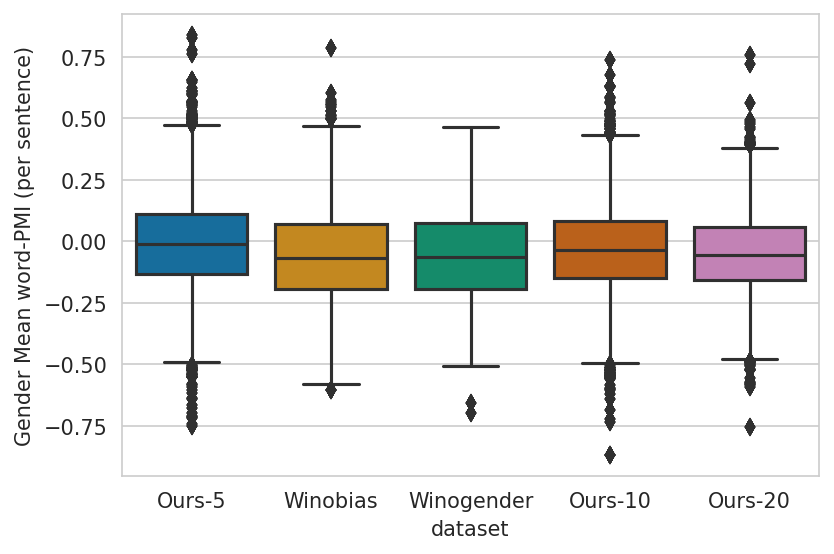

In [20]:
# arithmetic mean (unweighted, each term contributes the same)
def sentence_gender_mean(sentence_pmis: List[float], sentence_freqs: List[float]) -> float:
    if len(sentence_pmis) > 0:
        return np.mean(np.array(sentence_pmis))

# weighted average, each term is weighted in terms of its relative frequency
def sentence_gender_weightedmean(sentence_pmis: List[float], sentence_freqs: List[float], mult=True) -> float:
    if len(sentence_pmis) > 0:
        if mult:
            return np.mean(np.array(sentence_pmis) * np.array(sentence_freqs))
        else:
            return np.mean(np.array(sentence_pmis) + np.array(sentence_freqs))
    
    
# TODO -- SHOULD WE CONSIDER MASKING THE "ATTRIBUTE WORD" AND APPLY GENDER MAX PMI 
# TODO -- Apply MAX GENDER PMI w/ default values (if word does nto exist)
def sentence_gender_max(sentence_pmis: List[float]) -> float:
    if len(sentence_pmis) > 0:
        idx = np.argmax(np.abs(sentence_pmis))
        return sentence_pmis[idx]
    

def compute_measure_per_sentence_w_freq(
        pmi_per_templates: Dict[str, List[List[float]]],
        freq_per_templates: Dict[str, List[List[float]]],
        measure_fn: callable,
):
    results = defaultdict(list)
    for name, sentences in pmi_per_templates.items():
        for ix, sentence in enumerate(sentences):
            val = measure_fn(sentence, freq_per_templates[name][ix])

            results["dataset"].append(name)
            # for this work, the sentence must not have been sorted before in this notebook!!
            results["template_idx"].append(ix)
            results["value"].append(val)
            results["is_invalid"].append(len(sentence) == 0)

    return pd.DataFrame(results)


def compute_measure_per_sentence(pmi_per_templates: Dict[str, List[List[float]]], measure_fn: callable):
    results = defaultdict(list)
    for name, sentences in pmi_per_templates.items():
        for ix, sentence in enumerate(sentences):
            val = measure_fn(sentence)

            results["dataset"].append(name)
            # for this work, the sentence must not have been sorted before in this notebook!!
            results["template_idx"].append(ix)
            results["value"].append(val)
            results["is_invalid"].append(len(sentence) == 0)

    return pd.DataFrame(results)

# --------------------------------
# Arithmetic mean
# --------------------------------
RESULTS_GENDER_MEAN_PER_SENT = compute_measure_per_sentence_w_freq(PMI_PER_TEMPLATES, FREQ_PER_TEMPLATES, sentence_gender_mean)

plt.figure(figsize=(6, 4), dpi=150)
sns.boxplot(RESULTS_GENDER_MEAN_PER_SENT, x="dataset", y="value")
plt.ylabel("Gender Mean word-PMI (per sentence)")
plt.show()

# Table results
RESULTS_GENDER_MEAN_PER_SENT[["dataset", "value"]].groupby("dataset").describe().T[DATASET_ORDERING].style.format('{:.2f}')

In [21]:
word = [
    "breastfeeding",
    "breastfeeds",
    "breastfeed",
]
FREQ_WORDS[FREQ_WORDS.word.isin(word)]

,word,pmi_diff,counts,freq,log_freq
65668,breastfeeding,2.105636,838308,6.463257e-06,-11.949377
65698,breastfeed,2.158423,97390,7.508656e-07,-14.102039
65811,breastfeeds,2.465706,3748,2.889665e-08,-17.359540


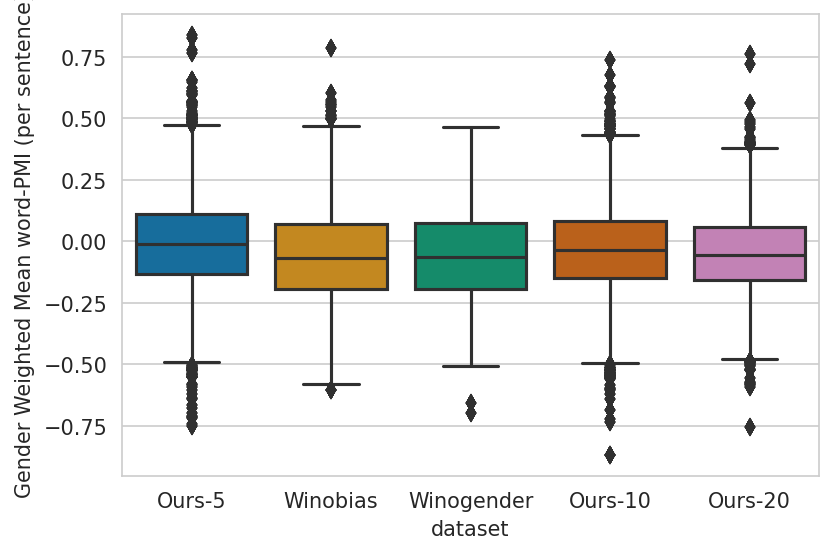

In [22]:
import functools

# --------------------------------
# Weighted average (WMEAN)
# --------------------------------
# If using log frequency, then call sentence_gender_Weigthedmean with mult=false --> it adds
__fn =  functools.partial(sentence_gender_weightedmean, mult=False)
RESULTS_GENDER_WMEAN_PER_SENT = compute_measure_per_sentence_w_freq(PMI_PER_TEMPLATES, LOGFREQ_PER_TEMPLATES, __fn)

plt.figure(figsize=(6, 4), dpi=150)
sns.boxplot(RESULTS_GENDER_WMEAN_PER_SENT, x="dataset", y="value")
plt.ylabel("Gender Weighted Mean word-PMI (per sentence)")
plt.show()

# Table results
RESULTS_GENDER_WMEAN_PER_SENT[["dataset", "value"]].groupby("dataset").describe().T[DATASET_ORDERING].style.format('{:.2f}')

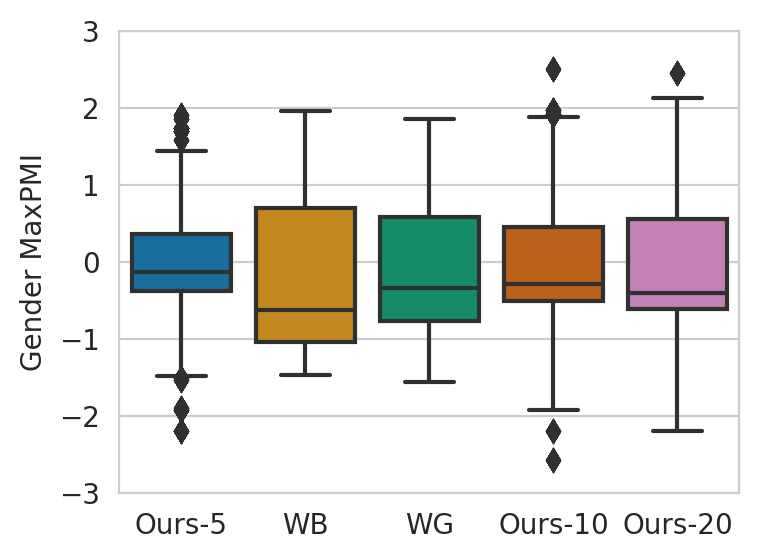

In [23]:
RESULTS_GENDER_MAX_PER_SENT = compute_measure_per_sentence(PMI_PER_TEMPLATES, sentence_gender_max)
RESULTS_GENDER_MAX_PER_SENT["dataset_"] = RESULTS_GENDER_MAX_PER_SENT.dataset.apply(lambda x: "WB" if x == "Winobias" else ("WG" if x == "Winogender" else x))

plt.figure(figsize=(4, 3), dpi=200)
sns.boxplot(RESULTS_GENDER_MAX_PER_SENT, x="dataset_", y="value")
plt.ylim(-3, 3)
plt.ylabel("Gender MaxPMI")
plt.xlabel(None)
plt.show()

# Table results
RESULTS_GENDER_MAX_PER_SENT[["dataset", "value"]].groupby("dataset").describe().T[DATASET_ORDERING].style.format('{:.2f}')

In [24]:
# Number of templates per dataset
num_templates = RESULTS_GENDER_MAX_PER_SENT.groupby("dataset").count()[["value"]]
num_templates.rename({"value": "orig_num_templates"}, axis=1, inplace=True)
num_templates

,orig_num_templates
dataset,
Ours-10,109020
Ours-20,111297
Ours-5,101292
Winobias,36478
Winogender,5520


### How many words have PMI defined per sentence?

In [25]:
__num_pmi_words_hyp = defaultdict(list)

for __dataset in DATANAMES:
    __pmi_words_in_ts = PMIWORDS_PER_TEMPLATES[__dataset]
    __num_pmi_words_hyp["dataset"].extend([__dataset] * len(__pmi_words_in_ts))
    __num_pmi_words_hyp["num_pmi_words"].extend([len(t) for t in __pmi_words_in_ts])
    __num_pmi_words_hyp["sum_pmi_sent"].extend([sum(v for (w, v) in t) for t in __pmi_words_in_ts])
    __num_pmi_words_hyp["avg_pmi_sent"].extend([np.mean([v for (w, v) in t]) for t in __pmi_words_in_ts])
    __num_pmi_words_hyp["log_weighted_avg_pmi_sent"].extend([np.mean([v * WORD2LOGFREQ[w] for (w, v) in t]) for t in __pmi_words_in_ts])
    __num_pmi_words_hyp["weighted_avg_pmi_sent"].extend([np.mean([v * WORD2FREQ[w] for (w, v) in t]) for t in __pmi_words_in_ts])

    __num_pmi_words_hyp["num_pos_pmi_sent"].extend([len([w for (w, v) in t if v > 0]) for t in __pmi_words_in_ts])
    __num_pmi_words_hyp["num_neg_pmi_sent"].extend([len([w for (w, v) in t if v < 0]) for t in __pmi_words_in_ts])

    # In this case, it's fine to use "split" because it will have the punctuation next to the words, so it won't 
    # double count the puctuation.
    __ts = DATANAME_TO_TEMPLATES[__dataset]
    __num_pmi_words_hyp["num_total_words"].extend([len(t.split()) for t in __ts])
    
__num_pmi_words_hyp = pd.DataFrame(__num_pmi_words_hyp)
__num_pmi_words_hyp["diff_polar"] = __num_pmi_words_hyp["num_pos_pmi_sent"] - __num_pmi_words_hyp["num_neg_pmi_sent"]

__num_pmi_words_hyp["ratio"] = __num_pmi_words_hyp["num_pmi_words"] / __num_pmi_words_hyp["num_total_words"]
__num_pmi_words_hyp.groupby("dataset").describe().T[DATASET_ORDERING]

/home/cbelem/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cbelem/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


dataset                     Ours-5        Ours-10        Ours-20  \
num_pmi_words count  101315.000000  109020.000000  111297.000000   
              mean        3.615891       6.308017      10.492250   
              std         1.174661       1.250684       1.904173   
              min         0.000000       2.000000       5.000000   
              25%         3.000000       6.000000       9.000000   
...                            ...            ...            ...   
ratio         min         0.000000       0.181818       0.263158   
              25%         0.500000       0.466667       0.478261   
              50%         0.600000       0.538462       0.526316   
              75%         0.600000       0.583333       0.578947   
              max         0.833333       0.818182       0.800000   

dataset                  Winobias   Winogender  
num_pmi_words count  36478.000000  5520.000000  
              mean       5.878941     6.291667  
              std        1.083758     1.548773  
              min        4.000000     3.000000  
              25%        5.000000     5.000000  
...                           ...          ...  
ratio         min        0.266667     0.250000  
              25%        0.416667     0.391304  
              50%        0.461538     0.433036  
              75%        0.500000     0.500000  
              max        0.666667     0.600000  

[80 rows x 5 columns]

### What's the correlation between number of words in the sentence and the max-gender PMI 
In this section, we compute the correlation between different aggregation measures at a sentence -level (i.e., a value per sentence) and how they correlated  with max-gender.

In [26]:
__max_gender_pmi = compute_measure_per_sentence(PMI_PER_TEMPLATES, sentence_gender_max)
__max_gender_pmi_w_length = pd.concat((__max_gender_pmi, __num_pmi_words_hyp.drop("dataset", axis=1)), axis=1)
__max_gender_pmi_w_length["value_abs"] = __max_gender_pmi_w_length["value"].apply(np.abs)
__max_gender_pmi_w_length.rename({"value": "maxpmi", "value_abs": "maxpmi_abs"}, axis=1, inplace=True)
__cols = list(__max_gender_pmi_w_length.columns[2:])
__cols = [c for c in __cols if c != "is_invalid"]

corr_per_dataset = {}

for dataname in DATANAMES:
    __df = __max_gender_pmi_w_length[__max_gender_pmi_w_length["dataset"] == dataname].copy()
    corr_per_dataset[dataname] = __df[__cols].corr("kendall")
    
# add one with all datasets too
corr_per_dataset["all"] = __max_gender_pmi_w_length[__cols].corr("kendall")

/home/cbelem/.conda/envs/py39/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


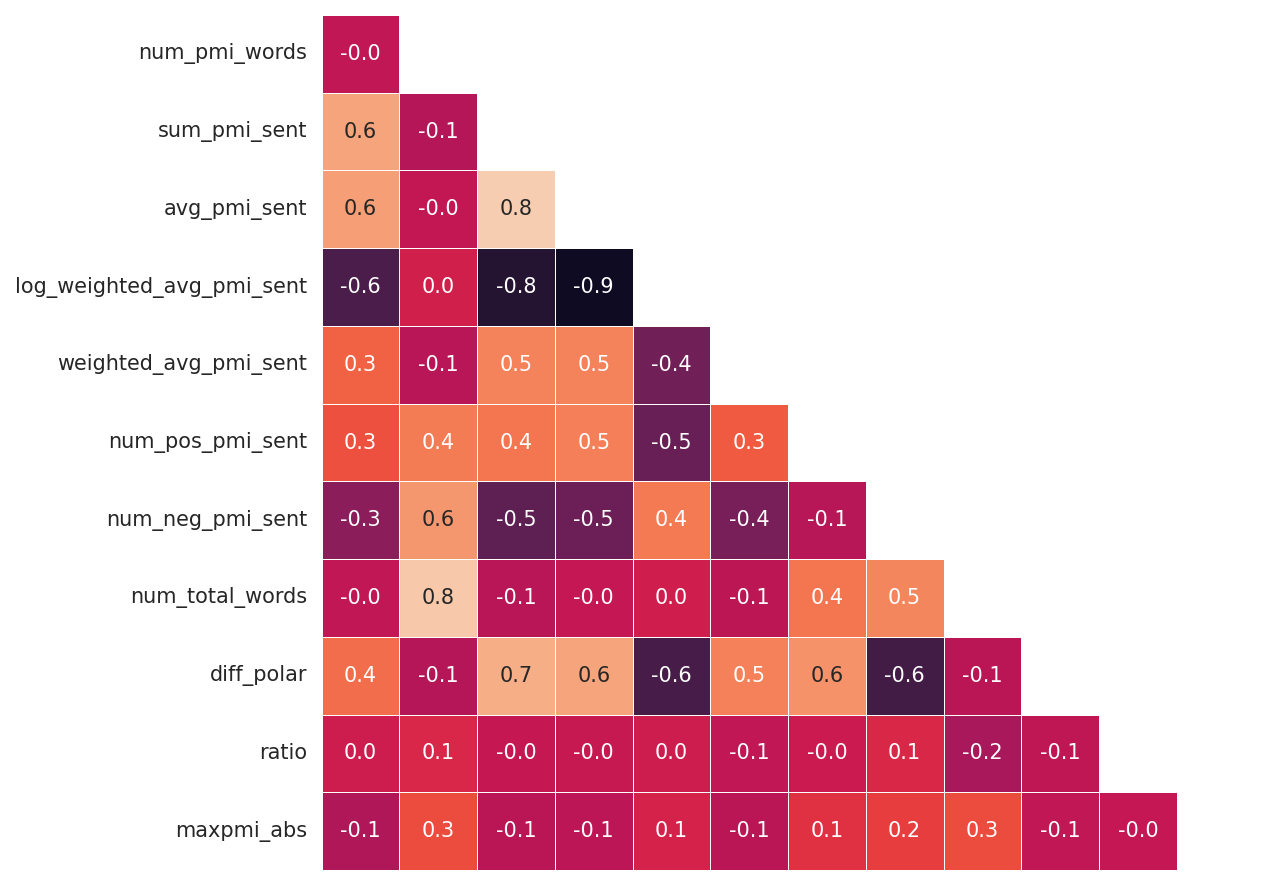

In [27]:
def correlation_plot(df_corr, figsize=(8, 6), dpi=150, **kwargs):
    mask = np.triu(df_corr)

    plt.figure(figsize=figsize, dpi=dpi)
    # drop first row
    df_corr = df_corr.drop("maxpmi")
    sns.heatmap(df_corr, mask=mask[1:,:], **kwargs)
    plt.xticks([], [])
    plt.tight_layout()
    plt.show()

kwargs = dict(vmin=-1, vmax=1, square=True, linewidths=.25, annot=True, fmt=".1f", cbar=None)#cbar_kws={"shrink": .80})
correlation_plot(corr_per_dataset["all"], **kwargs)

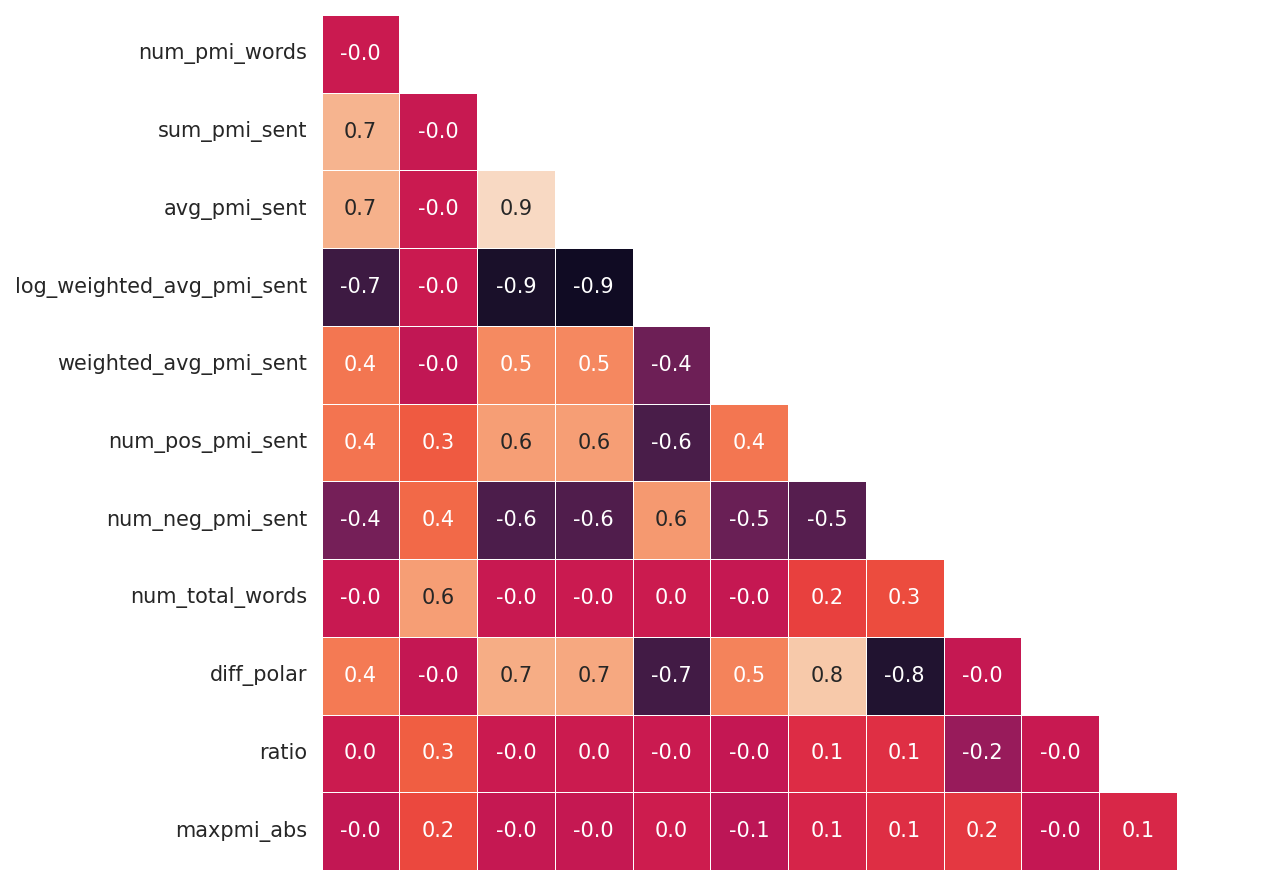

In [28]:
correlation_plot(corr_per_dataset["Ours-5"], **kwargs)

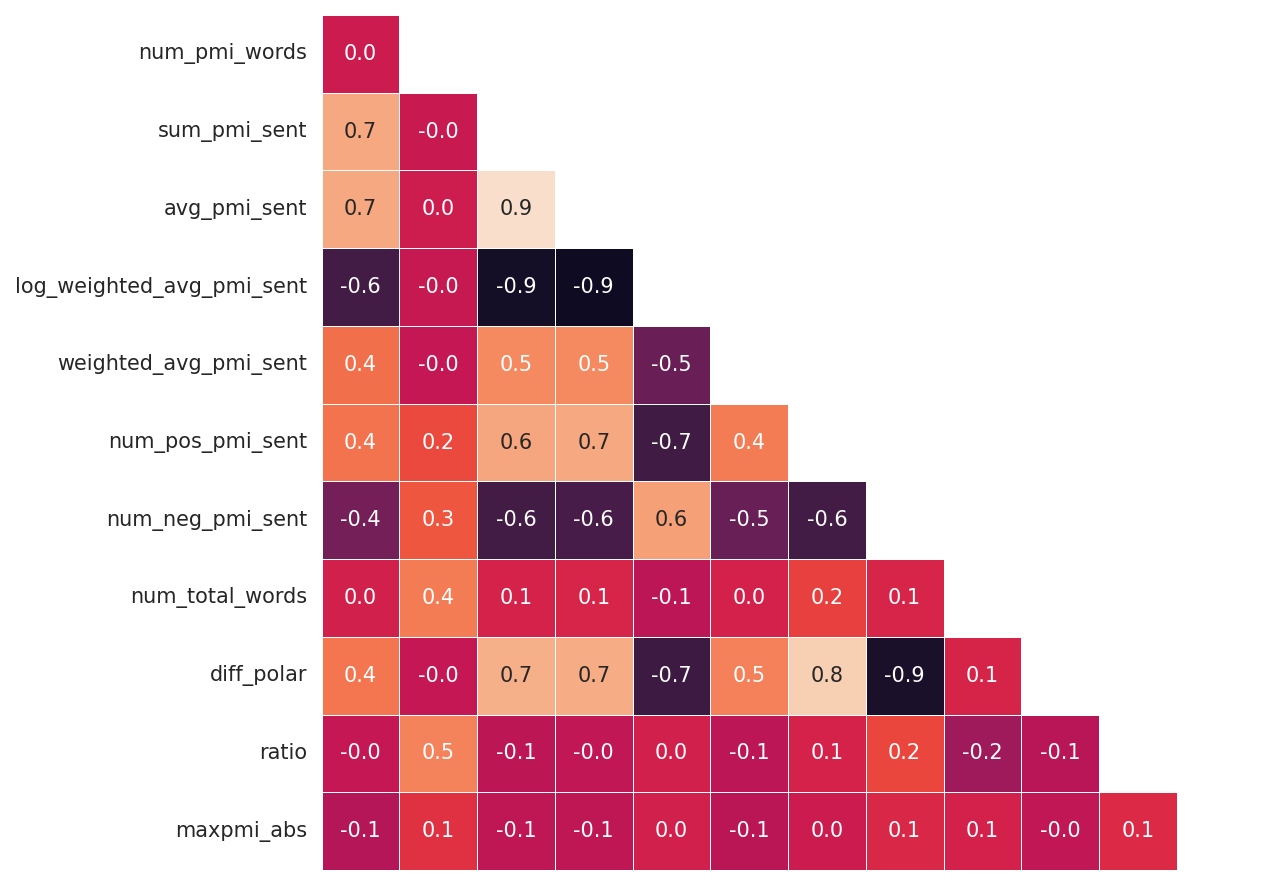

In [29]:
correlation_plot(corr_per_dataset["Ours-10"], **kwargs)

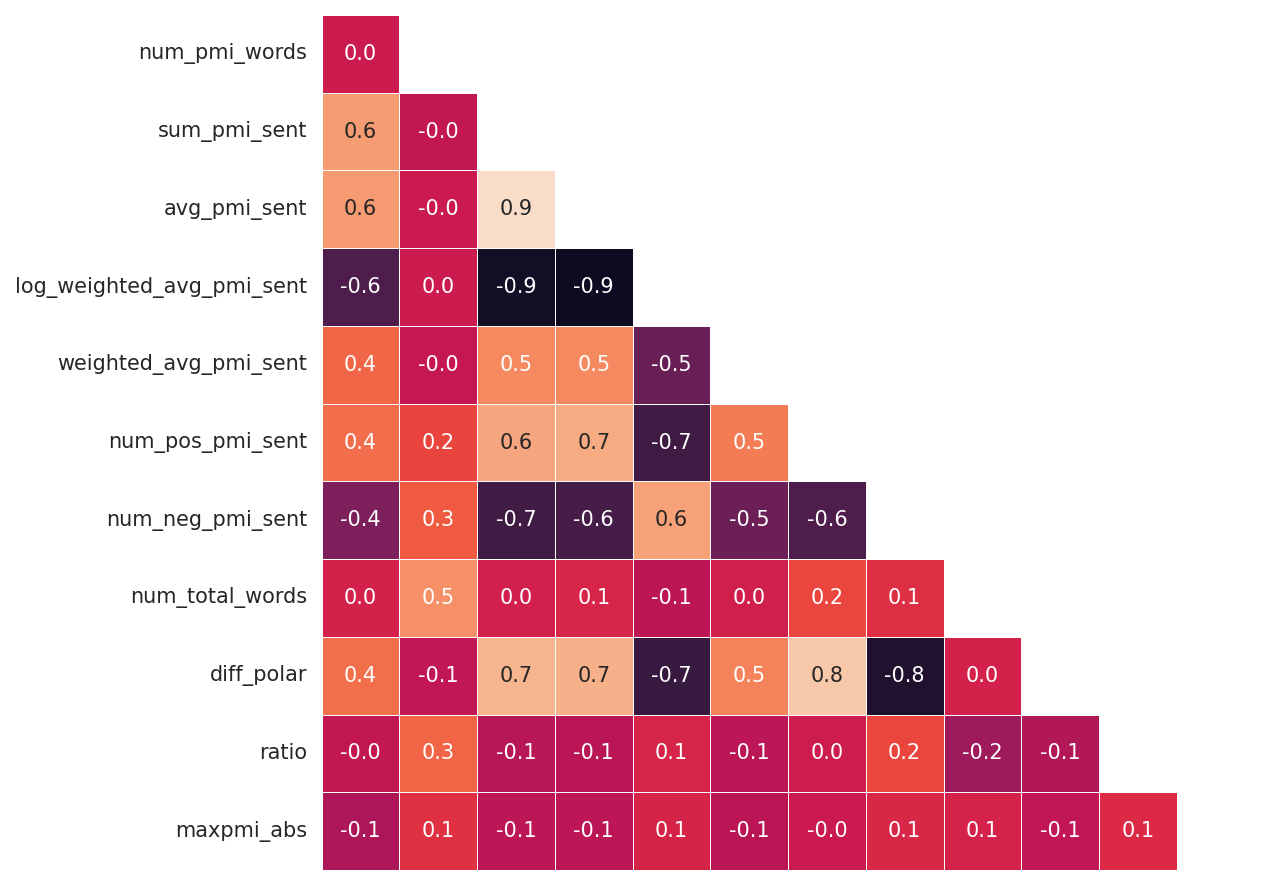

In [30]:
correlation_plot(corr_per_dataset["Ours-20"], **kwargs)

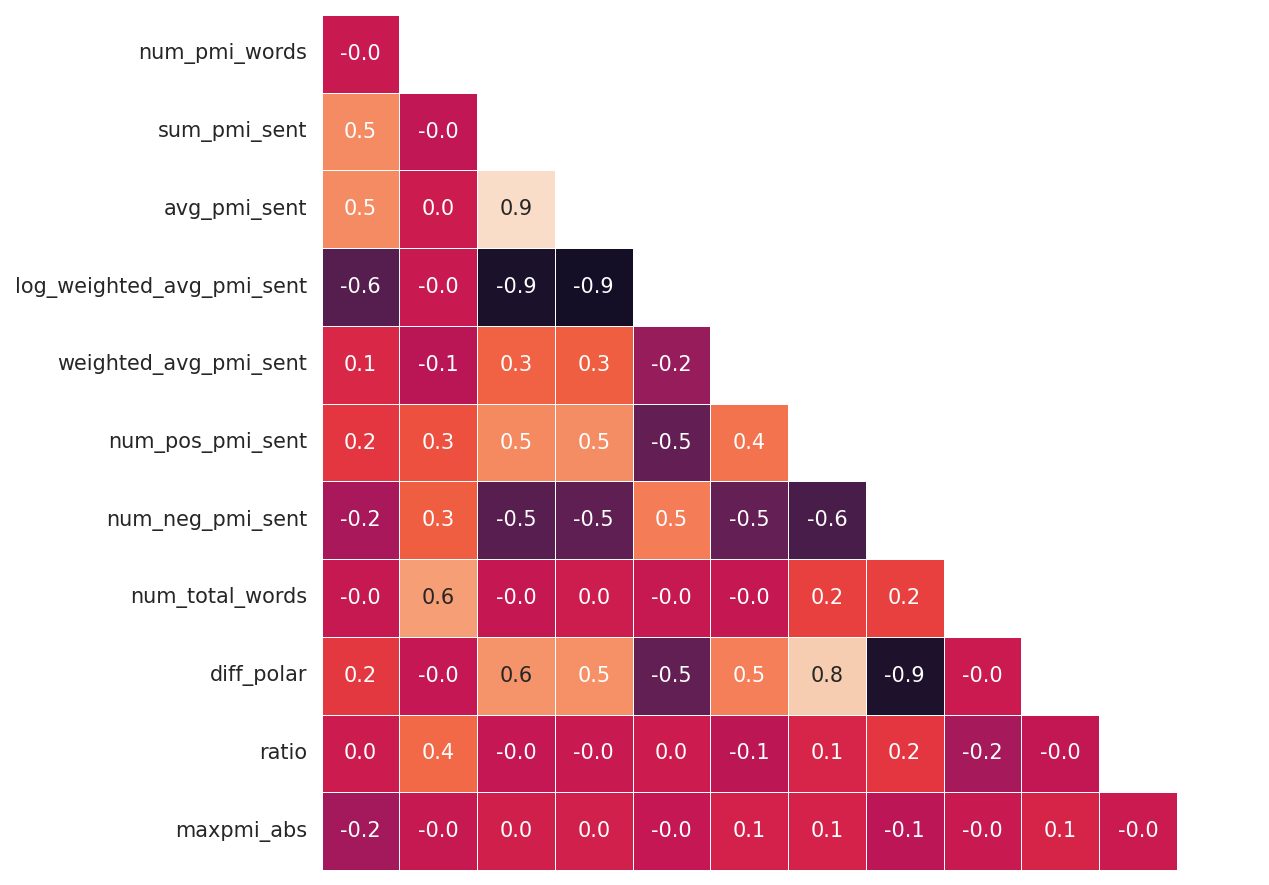

In [31]:
correlation_plot(corr_per_dataset["Winobias"], **kwargs)

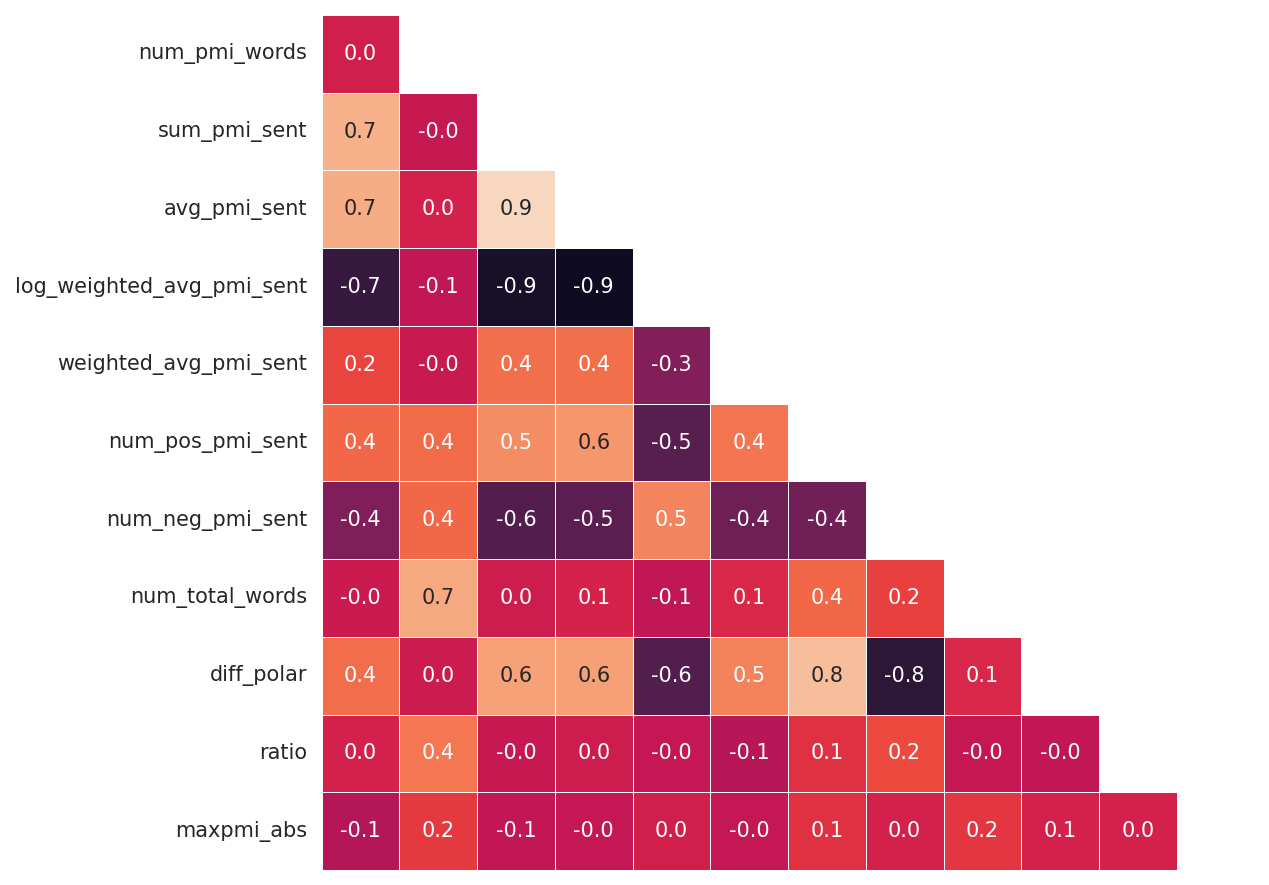

In [32]:
correlation_plot(corr_per_dataset["Winogender"], **kwargs)

In [33]:
dataset = "Winogender"
__max_gender_pmi_w_length[__max_gender_pmi_w_length.dataset == dataset][__cols]\
    .corr("kendall")

,maxpmi,num_pmi_words,sum_pmi_sent,avg_pmi_sent,log_weighted_avg_pmi_sent,weighted_avg_pmi_sent,num_pos_pmi_sent,num_neg_pmi_sent,num_total_words,diff_polar,ratio,maxpmi_abs
maxpmi,1.000000,0.035069,0.700233,0.678724,-0.710112,0.223322,0.360165,-0.353103,-0.000921,0.387792,0.049842,-0.116312
num_pmi_words,0.035069,1.000000,-0.016914,0.047892,-0.051514,-0.011135,0.376882,0.364481,0.654433,0.006201,0.435743,0.176661
sum_pmi_sent,0.700233,-0.016914,1.000000,0.896576,-0.869238,0.397726,0.526884,-0.563709,0.008584,0.620080,-0.019093,-0.051811
avg_pmi_sent,0.678724,0.047892,0.896576,1.000000,-0.928586,0.398354,0.564037,-0.516947,0.062067,0.611056,0.014794,-0.034225
log_weighted_avg_pmi_sent,-0.710112,-0.051514,-0.869238,-0.928586,1.000000,-0.338099,-0.539396,0.487664,-0.053263,-0.577675,-0.031702,0.031423
weighted_avg_pmi_sent,0.223322,-0.011135,0.397726,0.398354,-0.338099,1.000000,0.427480,-0.440289,0.083269,0.477899,-0.101267,-0.035767
num_pos_pmi_sent,0.360165,0.376882,0.526884,0.564037,-0.539396,0.427480,1.000000,-0.429346,0.360470,0.764546,0.137996,0.133525
num_neg_pmi_sent,-0.353103,0.364481,-0.563709,-0.516947,0.487664,-0.440289,-0.429346,1.000000,0.203302,-0.762522,0.248653,0.049134
num_total_words,-0.000921,0.654433,0.008584,0.062067,-0.053263,0.083269,0.360470,0.203302,1.000000,0.080343,-0.026604,0.160784
diff_polar,0.387792,0.006201,0.620080,0.611056,-0.577675,0.477899,0.764546,-0.762522,0.080343,1.000000,-0.049817,0.053177


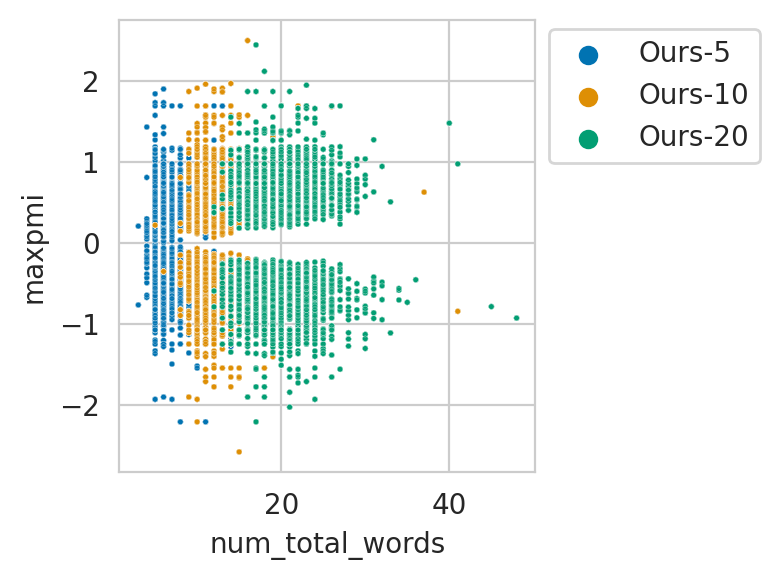

In [34]:
plt.figure(figsize=(4, 3), dpi=200)
mask = __max_gender_pmi_w_length.dataset.isin(("Ours-5", "Ours-10", "Ours-20"))
sns.scatterplot(__max_gender_pmi_w_length[mask], x="num_total_words", y="maxpmi", hue="dataset", s=4, alpha=0.50)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.tight_layout()
plt.show()

### What's the density of high level words per sentence (in each benchmark)

In [35]:
# compute number of words above threshold per sentence
MAX_PMI_THRESH = 0.65

__pmi_density = defaultdict(list)
for dataset, templates in PMIWORDS_PER_TEMPLATES.items():
    for templ in templates:
        high_pmi = [w for w, pmi in templ if np.abs(pmi) > MAX_PMI_THRESH]
        __pmi_density["dataset"].append(dataset)
        __pmi_density["num_high_pmi"].append(len(high_pmi))
        __pmi_density["ratio"].append(len(high_pmi) / len(templates))
            
__pmi_density = pd.DataFrame(__pmi_density)
__pmi_density.groupby('dataset').describe()

num_high_pmi                                               \
                  count      mean       std  min  25%  50%  75%  max   
dataset                                                                
Ours-10        109020.0  0.351055  0.630093  0.0  0.0  0.0  1.0  5.0   
Ours-20        111297.0  0.592478  0.854875  0.0  0.0  0.0  1.0  7.0   
Ours-5         101315.0  0.175709  0.422953  0.0  0.0  0.0  0.0  3.0   
Winobias        36478.0  1.044767  0.792401  0.0  0.0  1.0  2.0  4.0   
Winogender       5520.0  0.708333  0.717652  0.0  0.0  1.0  1.0  2.0   

               ratio                                                    \
               count      mean       std  min  25%       50%       75%   
dataset                                                                  
Ours-10     109020.0  0.000003  0.000006  0.0  0.0  0.000000  0.000009   
Ours-20     111297.0  0.000005  0.000008  0.0  0.0  0.000000  0.000009   
Ours-5      101315.0  0.000002  0.000004  0.0  0.0  0.000000  0.000000   
Winobias     36478.0  0.000029  0.000022  0.0  0.0  0.000027  0.000055   
Winogender    5520.0  0.000128  0.000130  0.0  0.0  0.000181  0.000181   

                      
                 max  
dataset               
Ours-10     0.000046  
Ours-20     0.000063  
Ours-5      0.000030  
Winobias    0.000110  
Winogender  0.000362

How many templates do we loose from each set by trimming the datasets based on the spurious correlations?

In [36]:
def filter_data_by_col_val(data:pd.DataFrame, col="value", thres=1):
    return data[(data[col] >= -thres) & (data[col] <= thres)]

def obtain_filtering_results(sentence_scores_per_sent, filtering_epsilons):
    filter_templates_results = {}
    for eps in filtering_epsilons:
        # number of examples after removing outliers outside [-1, 1]    
        df_eps = filter_data_by_col_val(sentence_scores_per_sent, thres=eps)

        # Obtain the number of remaining templates
        templ_diff = df_eps.groupby("dataset").count()["value"]
        # Obtain the difference in template counts by applying a specific filter.
        #templ_diff = df_eps.groupby("dataset").count()["value"] - num_templates["orig_num_templates"]
        filter_templates_results[round(eps, 2)] = templ_diff

    # How many templates we loose as we increase the filter
    filter_templates_results =  pd.DataFrame(filter_templates_results).T
    filter_templates_results = filter_templates_results.reset_index().rename({"index": "filter"}, axis=1)
    return filter_templates_results


FILTERING_EPSILONS = np.linspace(0.10, 2.5, 101)[::-1]
FILTERING_MAX_PER_SENT = obtain_filtering_results(RESULTS_GENDER_MAX_PER_SENT, FILTERING_EPSILONS)
FILTERING_MEAN_PER_SENT = obtain_filtering_results(RESULTS_GENDER_MEAN_PER_SENT, FILTERING_EPSILONS)
FILTERING_WMEAN_PER_SENT = obtain_filtering_results(RESULTS_GENDER_WMEAN_PER_SENT, FILTERING_EPSILONS)

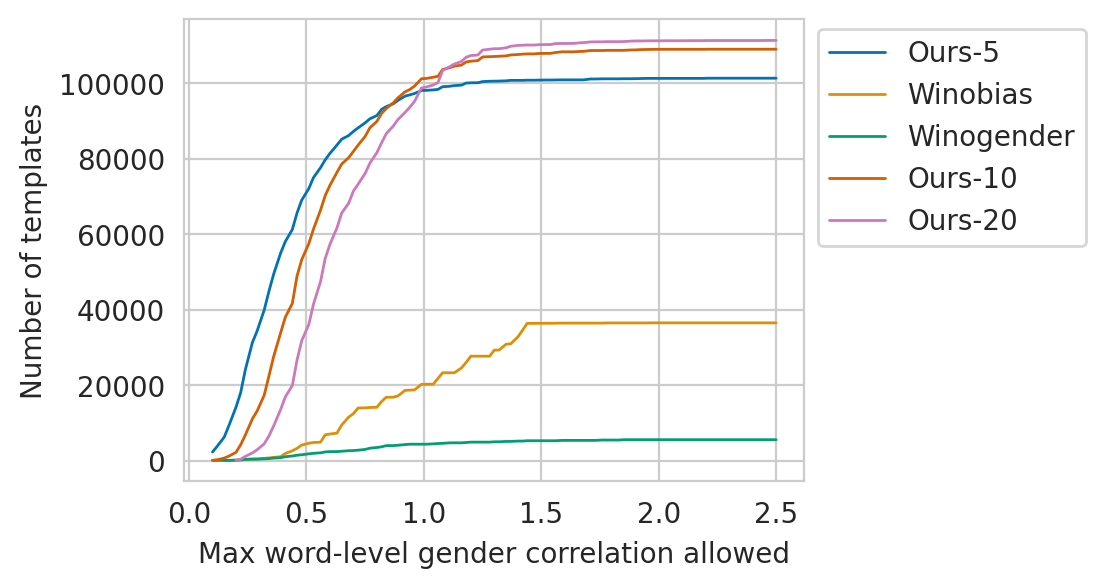

In [37]:
filter_templates_results = FILTERING_MAX_PER_SENT.copy()
plt.figure(figsize=(4,3), dpi=200)
for dataset in DATANAMES:
    sns.lineplot(filter_templates_results, x="filter", y=dataset, label=dataset, lw=1)

plt.xlabel("Max word-level gender correlation allowed")
plt.ylabel("Number of templates")
plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))

To ensure compatibility with the gender bias computation we had to load every model dataframe. So we have num_models * original data. We can account for that in the following line:

In [38]:
_filter_templates_results = filter_templates_results.copy() 
_filter_templates_results[DATASET_ORDERING] = (_filter_templates_results[DATASET_ORDERING] / NUM_EVAL_MODELS).fillna(0).astype(int) #/ _filter_templates_results[DATASET_ORDERING].iloc[0]).round(2) 

print(
    (_filter_templates_results[["filter"] + DATASET_ORDERING])\
      .to_latex(
            caption=f".",
            label="tab:tradeoff__maxpmi__num_templates",
    )
 )

_filter_templates_results[["filter"] + DATASET_ORDERING]

\begin{table}
\caption{.}
\label{tab:tradeoff__maxpmi__num_templates}
\begin{tabular}{lrrrrrr}
\toprule
dataset & filter & Ours-5 & Ours-10 & Ours-20 & Winobias & Winogender \\
\midrule
0 & 2.500000 & 4404 & 4738 & 4839 & 1586 & 240 \\
1 & 2.480000 & 4404 & 4738 & 4839 & 1586 & 240 \\
2 & 2.450000 & 4404 & 4738 & 4839 & 1586 & 240 \\
3 & 2.430000 & 4404 & 4738 & 4838 & 1586 & 240 \\
4 & 2.400000 & 4404 & 4738 & 4838 & 1586 & 240 \\
5 & 2.380000 & 4404 & 4738 & 4838 & 1586 & 240 \\
6 & 2.360000 & 4404 & 4738 & 4838 & 1586 & 240 \\
7 & 2.330000 & 4404 & 4738 & 4838 & 1586 & 240 \\
8 & 2.310000 & 4404 & 4738 & 4838 & 1586 & 240 \\
9 & 2.280000 & 4404 & 4738 & 4838 & 1586 & 240 \\
10 & 2.260000 & 4404 & 4738 & 4838 & 1586 & 240 \\
11 & 2.240000 & 4404 & 4738 & 4838 & 1586 & 240 \\
12 & 2.210000 & 4404 & 4738 & 4838 & 1586 & 240 \\
13 & 2.190000 & 4402 & 4737 & 4837 & 1586 & 240 \\
14 & 2.160000 & 4402 & 4737 & 4837 & 1586 & 240 \\
15 & 2.140000 & 4402 & 4737 & 4837 & 1586 & 240 \\
16 & 2.1

dataset,filter,Ours-5,Ours-10,Ours-20,Winobias,Winogender
0,2.50,4404,4738,4839,1586,240
1,2.48,4404,4738,4839,1586,240
2,2.45,4404,4738,4839,1586,240
3,2.43,4404,4738,4838,1586,240
4,2.40,4404,4738,4838,1586,240
...,...,...,...,...,...,...
96,0.20,614,94,4,2,5
97,0.17,403,51,0,1,2
98,0.15,270,28,0,1,2
99,0.12,164,9,0,0,2


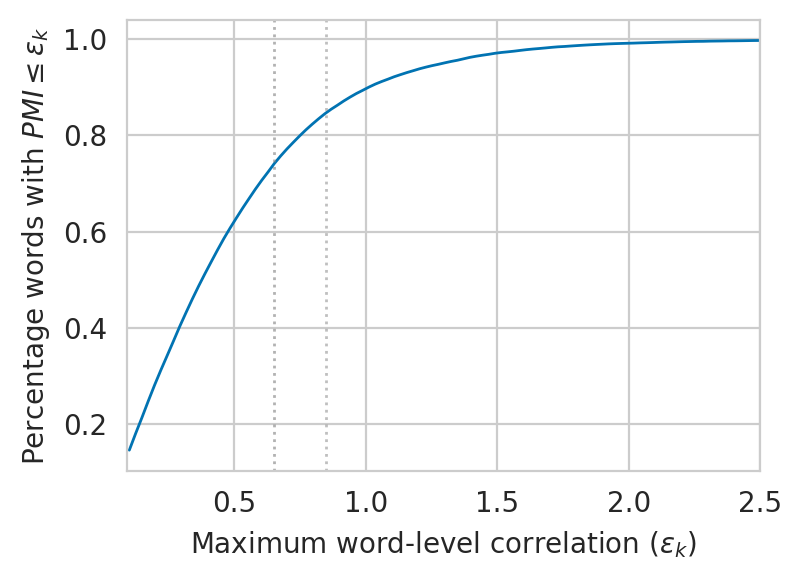

In [55]:
# TODO -- can also compute the pct of attribute words that remain after cropping up eps
num_words_w_filter_results = {eps: (PMI_DIFF["pmi_diff"].apply(np.abs) <= eps).sum() / len(PMI_DIFF) for eps in FILTERING_EPSILONS}
num_words_w_filter_results = pd.DataFrame(num_words_w_filter_results.items(), columns=["filter", "pct_words"])

plt.figure(figsize=(4,3), dpi=200)
sns.lineplot(num_words_w_filter_results, x="filter", y="pct_words", lw=1)

plt.xlabel("Maximum word-level correlation ($\epsilon_k$)")
plt.ylabel("Percentage words with $PMI \leq \epsilon_k$")
#plt.legend( loc='upper left', bbox_to_anchor=(0, -0.2), ncols=3)
plt.axvline(0.65, ls=":", color="gray", alpha=0.6, lw=1)
plt.axvline(0.85, ls=":", color="gray", alpha=0.5, lw=1)
plt.tight_layout()
plt.xlim(0.09, 2.5)
plt.show()

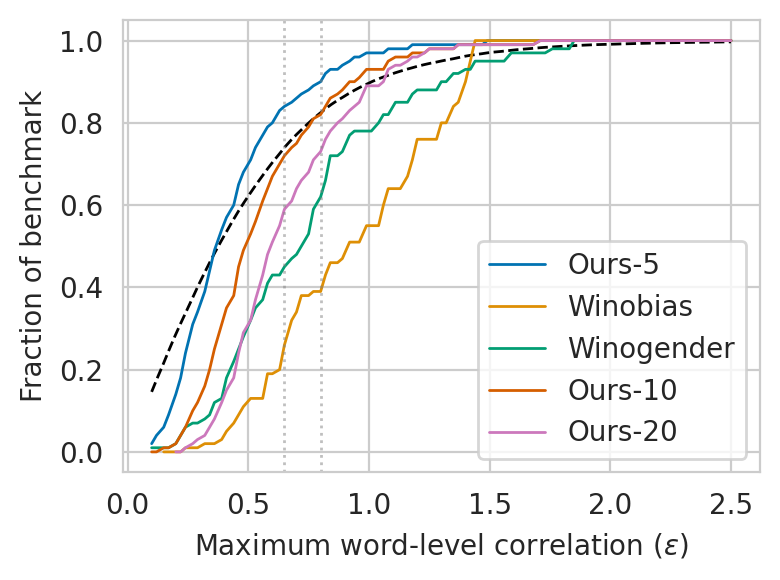

In [40]:
_filter_templates_results = filter_templates_results.copy() 
_filter_templates_results[DATASET_ORDERING] = (_filter_templates_results[DATASET_ORDERING] / _filter_templates_results[DATASET_ORDERING].iloc[0]).round(2) 


plt.figure(figsize=(4,3), dpi=200)
sns.lineplot(num_words_w_filter_results, x="filter", y="pct_words", lw=1, c="black", ls="--")

for dataset in DATANAMES:
    sns.lineplot(_filter_templates_results, x="filter", y=dataset, label=dataset, lw=1)

plt.xlabel("Maximum word-level correlation ($\epsilon$)")
plt.ylabel("Fraction of benchmark")
#plt.legend( loc='upper left', bbox_to_anchor=(0, -0.2), ncols=3)
plt.axvline(0.65, ls=":", color="gray", alpha=0.5, lw=1)
plt.axvline(0.80, ls=":", color="gray", alpha=0.5, lw=1)
plt.tight_layout()
plt.show()

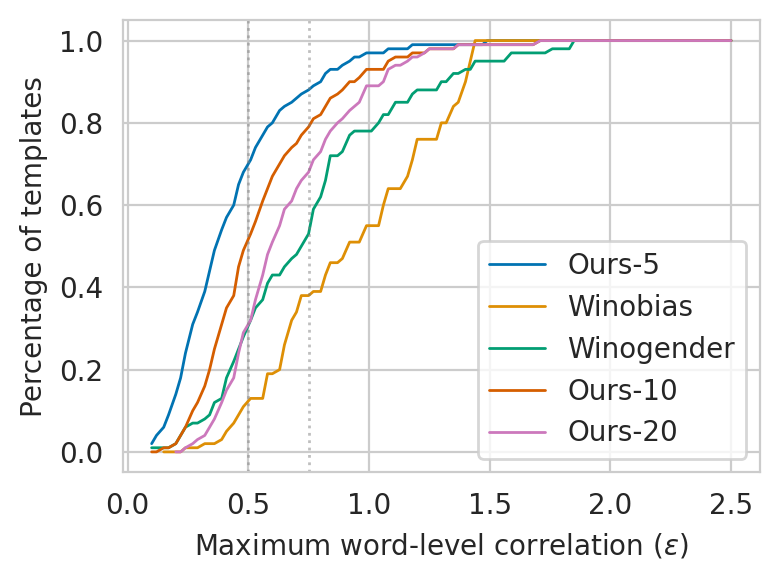

In [41]:
_filter_templates_results = filter_templates_results.copy() 
_filter_templates_results[DATASET_ORDERING] = (_filter_templates_results[DATASET_ORDERING] / _filter_templates_results[DATASET_ORDERING].iloc[0]).round(2) 


plt.figure(figsize=(4,3), dpi=200)
for dataset in DATANAMES:
    sns.lineplot(_filter_templates_results, x="filter", y=dataset, label=dataset, lw=1)

plt.xlabel("Maximum word-level correlation ($\epsilon$)")
plt.ylabel("Percentage of templates")
#plt.legend( loc='upper left', bbox_to_anchor=(0, -0.2), ncols=3)
plt.axvline(0.5, ls=":", color="gray", alpha=0.5, lw=1)
plt.axvline(0.75, ls=":", color="gray", alpha=0.5, lw=1)
plt.tight_layout()
plt.show()

In [42]:
DATASET_2_FILES["Ours-10"].columns

Index(['target_word', 'sentence', 'has_placeholder', 'template',
       'modifications', 'likely_under', 'is_natural', 'has_word', 'is_revised',
       'M_num_tokens', 'M_logprob', 'M_template', 'F_num_tokens', 'F_logprob',
       'F_template', 'FM_logprob', 'model', 'dataset', 'is_deduped', '__model',
       'model_basename', '__model_size'],
      dtype='object')

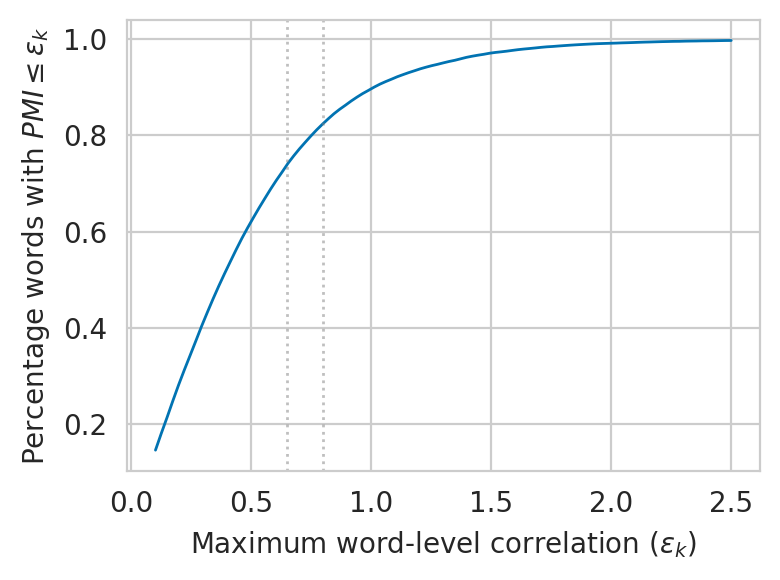

In [57]:
# TODO -- can also compute the pct of attribute words that remain after cropping up eps
num_words_w_filter_results = {eps: (PMI_DIFF["pmi_diff"].apply(np.abs) <= eps).sum() / len(PMI_DIFF) for eps in FILTERING_EPSILONS}
num_words_w_filter_results = pd.DataFrame(num_words_w_filter_results.items(), columns=["filter", "pct_words"])

plt.figure(figsize=(4,3), dpi=200)
sns.lineplot(num_words_w_filter_results, x="filter", y="pct_words", lw=1)

plt.xlabel("Maximum word-level correlation ($\epsilon_k$)")
plt.ylabel("Percentage words with $PMI \leq \epsilon_k$")
#plt.legend( loc='upper left', bbox_to_anchor=(0, -0.2), ncols=3)
plt.axvline(0.65, ls=":", color="gray", alpha=0.5, lw=1)
plt.axvline(0.80, ls=":", color="gray", alpha=0.5, lw=1)
plt.tight_layout()
plt.show()

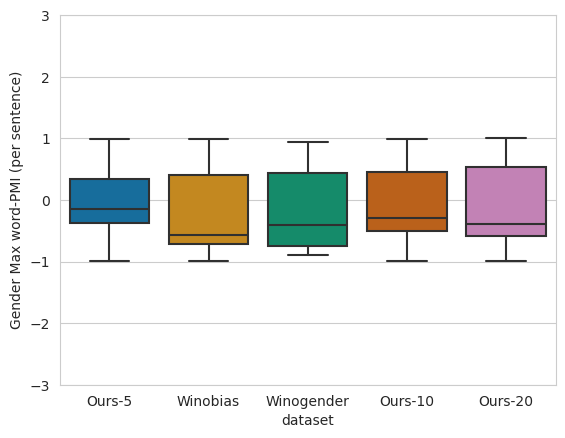

In [44]:
RESULTS_FILTER_BY_1 = filter_data_by_col_val(RESULTS_GENDER_MAX_PER_SENT, thres=1)
sns.boxplot(RESULTS_FILTER_BY_1, x="dataset", y="value")
plt.ylim(-3, 3)
plt.ylabel("Gender Max word-PMI (per sentence)")
plt.show()

RESULTS_FILTER_BY_1[["dataset", "value"]].groupby("dataset").describe().T[DATASET_ORDERING].style.format('{:.2f}')

In [45]:
WORD2PMI["secretary"], WORD2PMI["physician"], WORD2PMI["patient"]

(0.09741073662610233, -0.13730730584517303, 0.18206902072953213)

In [46]:
WORD2PMI["physician"], WORD2PMI["baker"], WORD2PMI["best"]

(-0.13730730584517303, 0.11993777048799359, -0.14770883602522034)

# Bias metric


In [47]:
# TODO 
# - Add fairness AUC

<_io.TextIOWrapper name='gender-wordlist/bias_attribute_words.json' mode='r' encoding='UTF-8'>

### 1. Filter examples

In [59]:
FILTER_GENDER_MAX_PMI = [0.65, 0.8, 1]

# To compute the values that we need for the paper, we will consider the thresholds 0.65 and 0.80 and 1

BIAS_FILES_BEF_DROPPED = {
    filt: { k: filter_data_by_col_val(f, k, RESULTS_GENDER_MAX_PER_SENT, eps=filt) for k, f in DATASET_2_FILES.items() }
    for filt in FILTER_GENDER_MAX_PMI
}

BIAS_FILES_AFT_DROPPED = {
    filt: {k: df[~df["is_dropped"]] for k, df in BIAS_FILES_BEF_DROPPED[filt].items()}
    for filt in FILTER_GENDER_MAX_PMI
}

for filt in FILTER_GENDER_MAX_PMI:
    for k in BIAS_FILES_BEF_DROPPED[filt].keys():
        print(filt, k, "\t", len(BIAS_FILES_BEF_DROPPED[filt][k]) / NUM_EVAL_MODELS, len(BIAS_FILES_AFT_DROPPED[filt][k])/NUM_EVAL_MODELS)

TypeError: 'DataFrame' object is not callable

In [ ]:
__d = BIAS_FILES_BEF_DROPPED[1]["Ours-5"] 
__d = __d[__d["__model"] == "EleutherAI__gpt-j-6b"]
__d["sentence"].value_counts()

In [ ]:
DEFAULT_PALETTE = sns.color_palette("colorblind", n_colors=len(DATASET_NAMES))
# Define dataset colors
DATASET_COLORS = {name: color for name, color in zip(DATASET_NAMES, DEFAULT_PALETTE)}

### Log-likelihood : automated  evaluation

In this section, we explore the use of a log-likelihood metric as the definition of model bias. In particular, we assume a model $\theta$ to be fair if it's log probability for a sentence $\mathbb{x} = x_1 x_2 ... x_L$ of length $L$ is equally likely if we replace the masculine pronouns with feminine pronouns. 

This pressuposes the sentence $\mathbb{x}$ is gender neutral and therefore should be equally likely under any gendered pronoun (regardless of whether it's a masculine/feminine or a non-binary set of pronouns). For simplicity, we'll make the analysis using the binary pronouns but it could be easily extend to include other non-binary pronouns. 

Mathematically, we encode this fairness notion as $P(\mathbb{x}^F; \theta) = P(\mathbb{x}^M; \theta)$ (or equivalently, $\frac{P(\mathbb{x}^F; \theta)}{P(\mathbb{x}^M; \theta)} = 1$), where we use the notation $\mathbb{x}^g$ to indicate the gendered pronouns used (F for female, M for male pronouns) and $P(\mathbb{x}; \theta)$ to be the probability assigned by the model parameterized by $\theta$. 

Given the difficulty of achieving exactly $P(\mathbb{x}^F; \theta) = P(\mathbb{x}^M; \theta) $, we relax our bias definition and instead deem a model $\epsilon$-fair if and only if the log-ratio of the probability of $\mathbb{x}^F$ and $\mathbb{x}^M$ satisfies:

$$
\log \frac{P(\mathbb{x}^F; \theta)}{P(\mathbb{x}^M; \theta)} \in \left[-\epsilon, \epsilon \right]
$$



### Which threshold to pick? 

Before we choose a _fixed threshold_, we will get a sense of how the pct of examples within $[-\epsilon, \epsilon]$ change as we increase $\epsilon$. We will call this the fairness_epsilons.

In [ ]:
FAIRNESS_EPSILONS = np.linspace(0, 10, 101)
FAIRNESS_COL = "FM_logprob"

FAIRNESS_EPSILONS[:5]

In [ ]:
def obtain_pct_examples_within_fair_threshold(data: pd.DataFrame, epsilons: list, col: str) -> pd.DataFrame:
    results = defaultdict(list)

    abs_col = data[col].apply(np.abs)
    for eps in epsilons:
        counts = (abs_col <= eps).sum()
        freq = counts / len(data)

        results["num_examples"].append(counts)
        results["pct_examples"].append(freq)
        results["epsilon"].append(eps)
    return pd.DataFrame(results)


def get_eps_logratio_curve_by_dataset(data2files, model, epsilons, col):
    results = []
    for dataset, df in data2files.items():
        print(dataset, len(df))
        model_df = df[df["model"] == model_name]
        pct = obtain_pct_examples_within_fair_threshold(model_df, epsilons, col)
        pct["model"] = model_name
        pct["dataset"] = dataset
        pct["is_baseline"] = not dataset.lower().startswith("ours-")
        results.append(pct)

    results = pd.concat(results)
    sns.lineplot(results, x="epsilon", y="pct_examples", hue="dataset", style="is_baseline")
    return results

### Plot model

In [ ]:
def get_eps_logratio_curve_by_model(data: pd.DataFrame, models, epsilons, col, **kwargs):
    df = data[data["model"].isin(models)].copy()
    
    results = []
    for model in models:
        model_df = df[df["model"] == model]
        print(model, len(df))

        if len(model_df) == 0:
            print(f"Skipping {model} because it doesn't exist")
            continue
            
        pct = obtain_pct_examples_within_fair_threshold(model_df, epsilons, col)
        pct["model"] = model.replace("__extra__ucinlp1__","")
        results.append(pct)

    results = pd.concat(results)
    sns.lineplot(results, x="epsilon", y="pct_examples", hue="model", **kwargs)

In [ ]:
FILTER = 1
PYTHIA_MODELS = [
    'pythia-70m',
    'pythia-160m',
    'pythia-1.4b',
    'pythia-2.8b',
    'pythia-6.9b',
    'pythia-12b',
    'gpt-j-6b',
]
# before dropping
get_eps_logratio_curve_by_model(BIAS_FILES_BEF_DROPPED[FILTER]["Ours-10"], PYTHIA_MODELS, FAIRNESS_EPSILONS, FAIRNESS_COL)
plt.show()
# after dropping
get_eps_logratio_curve_by_model(BIAS_FILES_AFT_DROPPED[FILTER]["Ours-10"], PYTHIA_MODELS, FAIRNESS_EPSILONS, FAIRNESS_COL)
plt.show()

In [ ]:
# before dropping
get_eps_logratio_curve_by_model(BIAS_FILES_BEF_DROPPED[FILTER]["Winogender"], PYTHIA_MODELS, FAIRNESS_EPSILONS, FAIRNESS_COL)
plt.show()
# after dropping
get_eps_logratio_curve_by_model(BIAS_FILES_AFT_DROPPED[FILTER]["Winogender"], PYTHIA_MODELS, FAIRNESS_EPSILONS, FAIRNESS_COL)
plt.show()

In [ ]:
PYTHIA_MODELS_DEDUP = [f"{m} (D)" for m in PYTHIA_MODELS if m != "gpt-j-6b"]
get_eps_logratio_curve_by_model(BIAS_FILES_BEF_DROPPED[FILTER]["Winobias"], PYTHIA_MODELS_DEDUP, FAIRNESS_EPSILONS, FAIRNESS_COL)
plt.show()
get_eps_logratio_curve_by_model(BIAS_FILES_AFT_DROPPED[FILTER]["Winobias"], PYTHIA_MODELS_DEDUP, FAIRNESS_EPSILONS, FAIRNESS_COL)
plt.show()

In [ ]:
OPT_MODELS = [
    'opt-125m',
    'opt-350m', 
    'opt-2.7b',
    'opt-6.7b'
]

get_eps_logratio_curve_by_model(BIAS_FILES_BEF_DROPPED[FILTER]["Ours-5"], OPT_MODELS, FAIRNESS_EPSILONS, FAIRNESS_COL)
plt.show()
get_eps_logratio_curve_by_model(BIAS_FILES_AFT_DROPPED[FILTER]["Ours-5"], OPT_MODELS, FAIRNESS_EPSILONS, FAIRNESS_COL)

In [ ]:
LLAMA_MODELS = [ 
    'llama-2_7B',
    'llama-2_13B',
    'mpt-7b',
    'mpt-30b',
]

get_eps_logratio_curve_by_model(BIAS_FILES_BEF_DROPPED[FILTER]["Winogender"], LLAMA_MODELS, FAIRNESS_EPSILONS, FAIRNESS_COL)
plt.show()
get_eps_logratio_curve_by_model(BIAS_FILES_AFT_DROPPED[FILTER]["Winogender"], LLAMA_MODELS, FAIRNESS_EPSILONS, FAIRNESS_COL)

#### Dataset

In [ ]:
model_name = "llama-2_13B"
get_eps_logratio_curve_by_dataset(BIAS_FILES_BEF_DROPPED[FILTER], model_name, FAIRNESS_EPSILONS, FAIRNESS_COL)
plt.xlabel("$\epsilon$ threshold")
plt.ylabel(f"% Examples with {FAIRNESS_COL} in $[-\epsilon, \epsilon]$")
plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))
plt.tight_layout()
plt.title(model_name)
#plt.savefig("./images/bias_metric____pct_neutral_in_func_epsilon.png")
plt.show()

get_eps_logratio_curve_by_dataset(BIAS_FILES_AFT_DROPPED[FILTER], model_name, FAIRNESS_EPSILONS, FAIRNESS_COL)
plt.xlabel("$\epsilon$ threshold")
plt.ylabel(f"% Examples with {FAIRNESS_COL} in $[-\epsilon, \epsilon]$")
plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))
plt.tight_layout()
plt.title(model_name)
#plt.savefig("./images/bias_metric____pct_neutral_in_func_epsilon.png")
plt.show()

## Pct of "neutral" for fixed threshold

In this section, we compute the number of examples that lie within the interval $[-\epsilon, \epsilon]$. To this end, we will have to compute the _skew_. We'll say the model skews male if the log ratio is in the interval $(-\infty, \epsilon]$. and skews female if is in the other extreme. 




In [ ]:
FIXED_FAIRNESS_THRESHOLD = 0.5
FAIRNESS_COL = "FM_logprob"

In [ ]:
import glob, operator


def is_neutral(df, col=FAIRNESS_COL, threshold: float=FIXED_FAIRNESS_THRESHOLD):
    assert 0 <= threshold <= 1
    assert col in df.columns
    return (df[col] >= -threshold) & (df[col] <= threshold)


def get_skew(df, col=FAIRNESS_COL, threshold: float=FIXED_FAIRNESS_THRESHOLD):
    assert 0 <= threshold <= 1
    assert col in df.columns

    df = df.copy()
    df["skew"] = ["neutral"] * len(df)
    df.loc[df[col] < -threshold, "skew"] = "male"
    df.loc[df[col] >  threshold, "skew"] = "female"
    return df["skew"]


def get_bins(val, max_val=100, edges=(15, 10, 5, 2.5, 1, FIXED_FAIRNESS_THRESHOLD)):
    __base_interval = pd.Interval(-edges[-1], edges[-1], closed="both")
    sign = np.sign(val)
    threshold = edges[-1]

    if sign == 0 or  -threshold <= val <= threshold:
        return __base_interval

    op = operator.gt if sign > 0 else operator.le
    edges = [sign * max_val] + [e * sign for e in edges]


    for i in range(1, len(edges)):
        if op(val, edges[i]):
            e1, e2 = edges[i-1], edges[i]
            bins = (e1, e2) if sign < 0 else (e2, e1)
            return pd.Interval(*bins, closed="neither" if sign < 0 and bins[-1] == -threshold else "right")

In [ ]:
def compute_skews_(data_files: dict, fairness_col, fairness_threshold):
    # Note: This cell is going to add columns to the original dataframes in DATASET_2_FILES
    for name, df in data_files.items():
        get_fair_bins = lambda x: get_bins(val=x, max_val=100, edges=(15, 10, 5, 2.5, 1, fairness_threshold))
        df[f"{fairness_col}_bins"] = df[fairness_col].apply(get_fair_bins)

        df["is_neutral"] = is_neutral(df, fairness_col, fairness_threshold)
        # Obtain a discrete measure of what gender does the model fairness_col, skews
        # note: it assumes that positive values of fairness col will skew female
        # completions; and negative values skew male completions...
        df["skew"] = get_skew(df, fairness_col, fairness_threshold)
        
    return data_files

In [ ]:
BIAS_FILES_BEF_DROPPED = {
    filt: compute_skews_(bias_files, FAIRNESS_COL, FIXED_FAIRNESS_THRESHOLD) for filt, bias_files in BIAS_FILES_BEF_DROPPED.items()
}

BIAS_FILES_AFT_DROPPED = {
    filt: compute_skews_(bias_files, FAIRNESS_COL, FIXED_FAIRNESS_THRESHOLD) for filt, bias_files in BIAS_FILES_AFT_DROPPED.items()
}

In [ ]:
DATA = BIAS_FILES_BEF_DROPPED[0.65]

# print(len(model_names) / NUM_EVAL_MODELS)
__scatter_results = defaultdict(list)

for dataset in DATANAMES:
    df = DATA[dataset].copy()
    __pct_examples = df.groupby(["__model", "skew"]).count()["template"]
    model_names = sorted(set(__pct_examples.index.get_level_values(0)))
    
    for model in model_names:
        _model_res = __pct_examples[model]

        total = _model_res.sum()
        __scatter_results["model"].append(model)
        __scatter_results["dataset"].append(dataset)
        __scatter_results["total"].append(total)
        __scatter_results["% neutral"].append(_model_res["neutral"] / total)
        __scatter_results["% female"].append(_model_res["female"] / total)
        __scatter_results["% male"].append(_model_res["male"] / total)
        __scatter_results["(% female) - (% male)"].append((_model_res["female"] - _model_res["male"]) / total)

__scatter_results = pd.DataFrame(__scatter_results)
assert __scatter_results["total"].nunique()==len(DATANAMES)

In [ ]:
__scatter_results.pivot_table(columns=["dataset"], values=["(% female) - (% male)"], index="model") * 100

In [ ]:
plt.figure(figsize=(6,4))

sns.scatterplot(__scatter_results, x="% female", y="% neutral", hue="dataset", s=20)
plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))

In [ ]:
def get_model_family(model):
    if "pythia" in model:
        return "pythia"
    elif "opt" in model:
        return "opt"
    elif "mpt" in model:
        return "mpt"
    elif "llama" in model:
        return "llama2"
    elif "gpt" in model:
        return "gpt-j"

    
def get_deduped(model):
    return "deduplicated" if 'dedup' in model else "none"


def get_training_set(family):
    if family in ("pythia", "gpt-j"):
        return "full"
    elif family in ("opt"):
        return "partial"
    else:
        return "unknown"
    
def get_model_size(size):
    MIL, BIL = 1, 1000
    if "6.9" in size:
        return 6.9 * BIL
    elif "6.7" in size:
        return 6.7 * BIL
    elif "70" in size:
        return 70 * MIL
    elif "7" in size:
        return 7 * BIL
    elif "6" in size:
        return 6 * BIL
    elif "2.8" in size:
        return 2.8 * BIL
    elif "2.7" in size:
        return 2.7 * BIL
    
    
__scatter_results["model family"] = __scatter_results.model.apply(get_model_family)
__scatter_results["Intervention"] = __scatter_results.model.apply(get_deduped)
__scatter_results["training set"] = __scatter_results["model family"].apply(get_training_set)

In [ ]:
__scatter_results.pivot(index="model", values=["(% female) - (% male)"], columns=["dataset"])

In [ ]:
# add boundaries
plt.figure(figsize=(6,4), dpi=200)

neutral_pcts = np.linspace(0, 0.5, 21)
# add margin
female_pcts = (1 - neutral_pcts)/2
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")

sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")

margins_20_pct_lowerbound = female_pcts - 0.2
margins_20_pct_upperbound = female_pcts + 0.2
plt.fill_betweenx(neutral_pcts, margins_20_pct_upperbound, margins_20_pct_lowerbound, color="lightgray", alpha=0.25)

margins_10_pct_lowerbound = female_pcts - 0.1
margins_10_pct_upperbound = female_pcts + 0.1
plt.fill_betweenx(neutral_pcts, margins_10_pct_upperbound, margins_10_pct_lowerbound, color="lightgray", alpha=0.35)


# Add annotations to each point
#for i in range(len(__scatter_results)):
#    label = __scatter_results.loc[i, "model"].rpartition("__")[-1]
#    if "12b" in label or "30b" in label:
#        x = __scatter_results.loc[i, "% female"]
#        y = __scatter_results.loc[i, "% neutral"]
#        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 0), ha='left')
sns.scatterplot(__scatter_results, x="% female", y="% neutral", hue="dataset", style="Intervention", alpha=0.8, edgecolor="black")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.xlabel("% predicted female")
plt.ylabel("% predicted neutral")
plt.tight_layout()

In [ ]:
# add boundaries
plt.figure(figsize=(6,4), dpi=200)

neutral_pcts = np.linspace(0, 0.5, 21)
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")
# add margin
female_pcts = (1 - neutral_pcts)/2
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")

margins_20_pct_lowerbound = female_pcts - 0.2
margins_20_pct_upperbound = female_pcts + 0.2
plt.fill_betweenx(neutral_pcts, margins_20_pct_upperbound, margins_20_pct_lowerbound, color="lightgray", alpha=0.25)

margins_10_pct_lowerbound = female_pcts - 0.1
margins_10_pct_upperbound = female_pcts + 0.1
plt.fill_betweenx(neutral_pcts, margins_10_pct_upperbound, margins_10_pct_lowerbound, color="lightgray", alpha=0.35)


ax = sns.scatterplot(__scatter_results, x="% female", y="% neutral", hue="dataset", style="model family", alpha=0.8, edgecolor="black")
# legend.texts[1].set_text('') 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.01))
plt.xlabel("% predicted female")
plt.ylabel("% predicted neutral")
plt.tight_layout()

In [ ]:
# add boundaries
plt.figure(figsize=(6,4), dpi=200)

neutral_pcts = np.linspace(0, 0.5, 21)
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")
# add margin
female_pcts = (1 - neutral_pcts)/2
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")

margins_20_pct_lowerbound = female_pcts - 0.2
margins_20_pct_upperbound = female_pcts + 0.2
plt.fill_betweenx(neutral_pcts, margins_20_pct_upperbound, margins_20_pct_lowerbound, color="lightgray", alpha=0.25)

margins_10_pct_lowerbound = female_pcts - 0.1
margins_10_pct_upperbound = female_pcts + 0.1
plt.fill_betweenx(neutral_pcts, margins_10_pct_upperbound, margins_10_pct_lowerbound, color="lightgray", alpha=0.35)


ax = sns.scatterplot(__scatter_results, x="% female", y="% neutral", hue="dataset", style="Intervention", alpha=0.8, edgecolor="black")
# ax.get_legend().remove()
plt.xlabel("% predicted female")
plt.ylabel("% predicted neutral")
plt.tight_layout()
plt.show()

In [ ]:
# add boundaries
plt.figure(figsize=(6,4), dpi=200)

neutral_pcts = np.linspace(0, 0.5, 21)
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")
# add margin
female_pcts = (1 - neutral_pcts)/2
sns.lineplot(x=female_pcts, y=neutral_pcts, ls='--', c="gray")

margins_20_pct_lowerbound = female_pcts - 0.2
margins_20_pct_upperbound = female_pcts + 0.2
plt.fill_betweenx(neutral_pcts, margins_20_pct_upperbound, margins_20_pct_lowerbound, color="lightgray", alpha=0.25)

margins_10_pct_lowerbound = female_pcts - 0.1
margins_10_pct_upperbound = female_pcts + 0.1
plt.fill_betweenx(neutral_pcts, margins_10_pct_upperbound, margins_10_pct_lowerbound, color="lightgray", alpha=0.35)


ax = sns.scatterplot(__scatter_results, x="% female", y="% neutral", hue="dataset",alpha=0.8, edgecolor="black")
plt.legend( loc='upper left', bbox_to_anchor=(1, 1.01))
plt.xlabel("% predicted female")
plt.ylabel("% predicted neutral")
plt.tight_layout()

## Figure 1. Get examples

In [ ]:
dataset = 'Ours-5'
examples_fig1 = BIAS_FILES_AFT_DROPPED[0.65][dataset].copy()
mask = ( 
    (examples_fig1["value"].apply(np.abs) <= 0.2)
    & (~examples_fig1["is_neutral"])
)
examples_fig1[mask].groupby(["template", "skew"]).count()["sentence"].to_csv(f"./{dataset}_filtered_examples_model_biased.csv")
examples_fig1[mask].groupby(["template", "skew"]).count()["sentence"]

## Percentage of examples $\in [-\epsilon, \epsilon]$

Let us compute the percentage of examples in each dataset that is within the specified threshold. We'll first create a table, as it is easier to represent in a paper.

In [ ]:
def get_pct_neutral_per_dataset(data_2_files: dict, use_filter_version=False):
    pct_neutral_per_dataset = {}

    for name, df in data_2_files.items():
        if use_filter_version and "is_natural" in df.columns:
            print("Filtering dataset", name, len(df))
            df = df[df["is_natural"]]
            print("Remaining", len(df))
        # Count number of neutral examples by model
        count_neutral = df.loc[df["is_neutral"]].groupby(["model"]).count()
        # Count total number of examples by model (should be the same for all of the models)
        count_total_sentences = df.groupby(["model"]).count()
        # The percentage is the number of neutral divided by the toal number of sentences
        pct_neutral_per_dataset[name] = (count_neutral / count_total_sentences)[["template"]]

    pct_neutral_per_dataset = pd.concat(pct_neutral_per_dataset).reset_index()
    pct_neutral_per_dataset.columns = ["dataset", "model_name", "is_neutral_pct"]
    
    return pct_neutral_per_dataset

### Compute pct neutral

Note by default the filtering (whether to use is_natural column) to filter the results is already being applied at the top of the document. Consider editing that cell to be able to perform filtering or unfiltering.

In [ ]:
col_ordering = ['Model', 'Ours-5', 'Ours-10', 'Ours-20', 'Winobias', 'Winogender']


def get_tables_pct(data2files,  use_filter_version=False, col_ordering=col_ordering):
    pct_neutral_per_dataset = get_pct_neutral_per_dataset(data2files, use_filter_version=use_filter_version)
    # print(len(pct_neutral_per_dataset))
    pct_neutral_table = pd.pivot(pct_neutral_per_dataset, values=["is_neutral_pct"], index="model_name", columns=["dataset"])

    pct_neutral_table_flat_header = pct_neutral_table.droplevel(None, axis=1).rename_axis(None, axis=1).reset_index() 
    #pct_neutral_table_flat_header.to_csv("./tables/bias_metric__pct_in_interval_0.5__by_model_and_dataset_with_likely_filter.csv")

    # Make model name canonical
    pct_neutral_table_flat_header["Model"] = \
        pct_neutral_table_flat_header.model_name.apply(canonic_model_name)

    pct_neutral_table_flat_header["_model"] = \
        pct_neutral_table_flat_header.Model.apply(lambda x: x.rpartition("-")[0])
    pct_neutral_table_flat_header["_size"] = \
        pct_neutral_table_flat_header.model_name.apply(get_model_size)

    pct_neutral_table_flat_header = pct_neutral_table_flat_header.sort_values(["_model", "_size"])

    # Format as pct but without % symbol
    pct_neutral_table_flat_header[col_ordering[1:]] = pct_neutral_table_flat_header[col_ordering[1:]] * 100


    #print(
    #    (pct_neutral_table_flat_header[col_ordering]).set_index("Model").to_latex(
    #        caption=f"Percentage of the examples per dataset and model with log-probability ratio in $[-{FIXED_FAIRNESS_THRESHOLD}, {FIXED_FAIRNESS_THRESHOLD}]$.",
    #        label="tab:bias-metric--pct-neutral-05--all-model-and-data-w-likely-filter",
    #        # Add pct formatter to all columns except model name
    #        formatters={c: '{:,.2f}'.format for c in col_ordering[1:]},
    #    )
    #)

    return pct_neutral_table_flat_header[col_ordering].set_index("Model")

In [ ]:
# tables before dropped should all have the same exact result (since the filtering was not applied)
# serves as a (weak) sanity check that the code is alright...
TABLES_BEF_DROPPED = {filt: get_tables_pct(bias_files, False) for filt, bias_files in BIAS_FILES_BEF_DROPPED.items()}

# 
TABLES_AFT_DROPPED = {filt: get_tables_pct(bias_files, False) for filt, bias_files in BIAS_FILES_AFT_DROPPED.items()}

In [ ]:
TABLES_BEF_DROPPED[0.65].round(2)

In [ ]:
TABLES_AFT_DROPPED[1].round(2)

In [ ]:
TABLES_BEF_DROPPED[0.65].round(2).max(axis=0)

In [ ]:
TABLES_AFT_DROPPED[0.65] - TABLES_BEF_DROPPED[0.65]

In [ ]:
TABLES_AFT_DROPPED[0.80] - TABLES_BEF_DROPPED[0.65]

In [ ]:
TABLES_AFT_DROPPED[1] - TABLES_BEF_DROPPED[0.65]

In [ ]:
TABLES_AFT_DROPPED[0.65].max(axis=0)

In [ ]:
TABLES_AFT_DROPPED.keys()

In [ ]:
#unfilt_table_bef_drop = get_tables_pct(BIAS_FILES_BEF_DROPPED, False)
#unfilt_table_aft_drop = get_tables_pct(BIAS_FILES_AFT_DROPPED, False)

filt_table_bef_drop = get_tables_pct(BIAS_FILES_BEF_DROPPED, True)
filt_table_aft_drop = get_tables_pct(BIAS_FILES_AFT_DROPPED, True)

In [ ]:
unfilt_table_aft_drop.head(2)

In [ ]:
unfilt_table_bef_drop.head(2)

In [ ]:
filt_table_bef_drop.style.background_gradient(axis=1, cmap='Greens', vmin=0, vmax=100)

In [ ]:
filt_table_aft_drop.style.background_gradient(axis=1, cmap='Greens', vmin=0, vmax=100)

In [ ]:
(100 - filt_table_bef_drop).style.background_gradient(axis=1, cmap='Reds', vmin=0, vmax=100)

In [ ]:
len(
"Do large language models still favor one gender over the other in non-stereotypical settings? We study this question in the gender pronoun setting and show that, surprisingly, 20 popular LLMs still exhibit gender bias in 50-90% of the examples")

In [ ]:
(100 - filt_table_bef_drop).mean()

In [ ]:
(100 -filt_table_aft_drop).style.background_gradient(axis=1, cmap='Reds', vmin=0, vmax=100)

In [ ]:
((100-filt_table_aft_drop) - (100 - filt_table_bef_drop)).min()

In [ ]:
(filt_table_aft_drop - filt_table_bef_drop).style.background_gradient(axis=1, cmap='coolwarm_r', vmin=-50, vmax=50)

In [ ]:
pct_neutral_per_dataset = get_pct_neutral_per_dataset(BIAS_FILES_BEF_DROPPED, use_filter_version=False)
pct_neutral_table = pd.pivot(pct_neutral_per_dataset, values=["is_neutral_pct"], index="model_name", columns=["dataset"])

pct_neutral_table_flat_header = pct_neutral_table.droplevel(None, axis=1).rename_axis(None, axis=1).reset_index() 
pct_neutral_table_flat_header.to_csv("./tables/bias_metric__pct_in_interval_0.5__by_model_and_dataset.csv")

# Make model name canonical
pct_neutral_table_flat_header["Model"] = \
    pct_neutral_table_flat_header.model_name.apply(canonic_model_name)

pct_neutral_table_flat_header["_model"] = \
    pct_neutral_table_flat_header.Model.apply(lambda x: x.rpartition("-")[0])
pct_neutral_table_flat_header["_size"] = \
    pct_neutral_table_flat_header.model_name.apply(get_model_size)

pct_neutral_table_flat_header = pct_neutral_table_flat_header.sort_values(["_model", "_size"])

# Order the datasets
# col_ordering = ['Model', 'Ours-5', 'Ours-10', 'Ours-20', 'StereoSet', 'Winobias', 'Winogender']

# Format as pct but without % symbol
pct_neutral_table_flat_header[col_ordering[1:]] = pct_neutral_table_flat_header[col_ordering[1:]] * 100


print(
    (pct_neutral_table_flat_header[col_ordering]).set_index("Model").to_latex(
        caption=f"Percentage of the examples per dataset and model with log-probability ratio in $[-{FIXED_FAIRNESS_THRESHOLD}, {FIXED_FAIRNESS_THRESHOLD}]$.",
        label="tab:bias-metric--pct-neutral-05--all-model-and-data",
        # Add pct formatter to all columns except model name
        formatters={c: '{:,.2f}'.format for c in col_ordering[1:]},
    )
)

pct_neutral_table_flat_header[col_ordering].set_index("Model")

In [ ]:
pct_neutral_per_dataset = get_pct_neutral_per_dataset(BIAS_FILES_AFT_DROPPED, use_filter_version=False)
pct_neutral_table = pd.pivot(pct_neutral_per_dataset, values=["is_neutral_pct"], index="model_name", columns=["dataset"])

pct_neutral_table_flat_header = pct_neutral_table.droplevel(None, axis=1).rename_axis(None, axis=1).reset_index() 
#pct_neutral_table_flat_header.to_csv("./tables/bias_metric__pct_in_interval_0.5__by_model_and_dataset.csv")

# Make model name canonical
pct_neutral_table_flat_header["Model"] = \
    pct_neutral_table_flat_header.model_name.apply(canonic_model_name)

pct_neutral_table_flat_header["_model"] = \
    pct_neutral_table_flat_header.Model.apply(lambda x: x.rpartition("-")[0])
pct_neutral_table_flat_header["_size"] = \
    pct_neutral_table_flat_header.model_name.apply(get_model_size)

pct_neutral_table_flat_header = pct_neutral_table_flat_header.sort_values(["_model", "_size"])


# Format as pct but without % symbol
pct_neutral_table_flat_header[col_ordering[1:]] = pct_neutral_table_flat_header[col_ordering[1:]] * 100


print(
    (pct_neutral_table_flat_header[col_ordering]).set_index("Model").to_latex(
        caption=f"Percentage of the examples per dataset and model with log-probability ratio in $[-{FIXED_FAIRNESS_THRESHOLD}, {FIXED_FAIRNESS_THRESHOLD}]$.",
        label="tab:bias-metric--pct-neutral-05--all-model-and-data",
        # Add pct formatter to all columns except model name
        formatters={c: '{:,.2f}'.format for c in col_ordering[1:]},
    )
)

pct_neutral_table_flat_header[col_ordering].set_index("Model")

### with filter

In [ ]:
pct_neutral_per_dataset = get_pct_neutral_per_dataset(BIAS_FILES_BEF_DROPPED, use_filter_version=True)
pct_neutral_table = pd.pivot(pct_neutral_per_dataset, values=["is_neutral_pct"], index="model_name", columns=["dataset"])

pct_neutral_table_flat_header = pct_neutral_table.droplevel(None, axis=1).rename_axis(None, axis=1).reset_index() 
pct_neutral_table_flat_header.to_csv("./tables/bias_metric__pct_in_interval_0.5__by_model_and_dataset_with_likely_filter.csv")

# Make model name canonical
pct_neutral_table_flat_header["Model"] = \
    pct_neutral_table_flat_header.model_name.apply(canonic_model_name)

pct_neutral_table_flat_header["_model"] = \
    pct_neutral_table_flat_header.Model.apply(lambda x: x.rpartition("-")[0])
pct_neutral_table_flat_header["_size"] = \
    pct_neutral_table_flat_header.model_name.apply(get_model_size)

pct_neutral_table_flat_header = pct_neutral_table_flat_header.sort_values(["_model", "_size"])

# Format as pct but without % symbol
pct_neutral_table_flat_header[col_ordering[1:]] = pct_neutral_table_flat_header[col_ordering[1:]] * 100


print(
    (pct_neutral_table_flat_header[col_ordering]).set_index("Model").to_latex(
        caption=f"Percentage of the examples per dataset and model with log-probability ratio in $[-{FIXED_FAIRNESS_THRESHOLD}, {FIXED_FAIRNESS_THRESHOLD}]$.",
        label="tab:bias-metric--pct-neutral-05--all-model-and-data-w-likely-filter",
        # Add pct formatter to all columns except model name
        formatters={c: '{:,.2f}'.format for c in col_ordering[1:]},
    )
)

pct_neutral_table_flat_header[col_ordering].set_index("Model")

In [ ]:
pct_neutral_per_dataset = get_pct_neutral_per_dataset(DATASET_2_FILES, use_filter_version=True)
pct_neutral_table = pd.pivot(pct_neutral_per_dataset, values=["is_neutral_pct"], index="model_name", columns=["dataset"])

pct_neutral_table_flat_header = pct_neutral_table.droplevel(None, axis=1).rename_axis(None, axis=1).reset_index() 
pct_neutral_table_flat_header.to_csv("./tables/bias_metric__pct_in_interval_0.5__by_model_and_dataset_with_likely_filter.csv")

# Make model name canonical
pct_neutral_table_flat_header["Model"] = \
    pct_neutral_table_flat_header.model_name.apply(canonic_model_name)

pct_neutral_table_flat_header["_model"] = \
    pct_neutral_table_flat_header.Model.apply(lambda x: x.rpartition("-")[0])
pct_neutral_table_flat_header["_size"] = \
    pct_neutral_table_flat_header.model_name.apply(get_model_size)

pct_neutral_table_flat_header = pct_neutral_table_flat_header.sort_values(["_model", "_size"])

# Order the datasets
col_ordering = ['Model', 'Ours-5', 'Ours-10', 'Ours-20', 'StereoSet', 'Winobias', 'Winogender']

# Format as pct but without % symbol
pct_neutral_table_flat_header[col_ordering[1:]] = pct_neutral_table_flat_header[col_ordering[1:]] * 100


print(
    (pct_neutral_table_flat_header[col_ordering]).set_index("Model").to_latex(
        caption=f"Percentage of the examples per dataset and model with log-probability ratio in $[-{FIXED_FAIRNESS_THRESHOLD}, {FIXED_FAIRNESS_THRESHOLD}]$.",
        label="tab:bias-metric--pct-neutral-05--all-model-and-data-w-likely-filter",
        # Add pct formatter to all columns except model name
        formatters={c: '{:,.2f}'.format for c in col_ordering[1:]},
    )
)

pct_neutral_table_flat_header[col_ordering].set_index("Model")

In [ ]:

    
pct_neutral_table_flat_header["model_size"] = pct_neutral_table_flat_header["model_name_canonic"].apply(get_model_size)